In [1]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shlex
from scipy.stats import ttest_rel,ttest_ind,wilcoxon,ranksums,pearsonr,spearmanr
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import explained_variance_score,mean_squared_error
from statsmodels.stats.multitest import multipletests
import subprocess
import scipy
from analysis_utils import *

# Initial analysis of raw data

In [2]:
data_meta={'index':[],'seq':[],'tf':[],'filler':[],'type':[],'nmotif':[],'distance':[],
           'background':[],'control':[],'ES score':[],'ED score':[]}
meta_keys=list(data_meta.keys())
for line in open('../tf_combo_library_generation/combinatorial_library_1927_70nt.data'):
    splitter = shlex.shlex(line.strip())
    splitter.whitespace += ','
    splitter.whitespace_split = True
    data=list(splitter)
    if len(data) < len(meta_keys):
        if 'CAT' not in data[2]:
            meta_key_ind=0
            for i in range(len(data)):
                if meta_keys[meta_key_ind] == 'filler':
                    data_meta[meta_keys[meta_key_ind]].append('N/A')
                    meta_key_ind+=1
                data_meta[meta_keys[meta_key_ind]].append(data[i])
                meta_key_ind+=1
        else:
            for i in range(len(data)):
                data_meta[meta_keys[i]].append(data[i])
            for n in range(i+1,len(meta_keys)):
                data_meta[meta_keys[n]].append('')
    else:
        for i in range(len(data)):
            data_meta[meta_keys[i]].append(data[i])
print([(d,len(data_meta[d])) for d in meta_keys])
meta_df = pd.DataFrame(data_meta)
meta_df.head()

[('index', 1927), ('seq', 1927), ('tf', 1927), ('filler', 1927), ('type', 1927), ('nmotif', 1927), ('distance', 1927), ('background', 1927), ('control', 1927), ('ES score', 1927), ('ED score', 1927)]


index                                                seq     tf filler  \
0     8  GACTGTACCGAAGAGACAGCAACTGAGAGTGCCATTGTTTTGGGCT...  sox17    N/A   
1     9  TCCGAGTACGCAGTATGATCACAGGACAGCTCGCCATGCTTCAGGA...  sox17    N/A   
2    10  GAGGTCTGACTTCTGTGTAAAGCCCCGCCCGCCATTGTTTTAAACA...  sox17    N/A   
3    11  GCAGGTGCCAACTATCACCTTGCGTTTCTCGTTGTTAATCGTGAGT...  sox17    N/A   
4    12  CATAAACGCACCTTGTATAATCTATAGATTGCCATTGTTTTTCGAC...  sox17    N/A   

        type nmotif distance               background    control  \
0  homotypic      1        6            "1470,-,None"      motif   
1  homotypic      1        6            "1470,-,None"  scrambled   
2  homotypic      1        6            "1505,-,None"      motif   
3  homotypic      1        6            "1505,-,None"  scrambled   
4  homotypic      1        6  "1308,scrambled-1,None"      motif   

              ES score            ED score  
0  0.47275000511270915  0.5204351973815456  
1   0.5924902218383735  0.5770268332252266  
2  0.45349155182067813  0.4057529381156254  
3  0.44670208703299025  0.5699520865465608  
4  0.41139989523146536  0.3468925858985108

In [3]:
df1 = pd.read_table('/data/cgs/krismer/projects/res-acc/phrase-library-v4/analysis/phrases-reads-matrix.txt')
df2 = pd.read_table('/data/cgs/krismer/projects/res-acc/phrase-library-v4-endo/analysis/phrases-reads-matrix.txt')
df = df1.merge(df2,on=['seq','tf'])
print(len(df))
df.head()

1927


seq     tf  \
0  GACTGTACCGAAGAGACAGCAACTGAGAGTGCCATTGTTTTGGGCT...  sox17   
1  TCCGAGTACGCAGTATGATCACAGGACAGCTCGCCATGCTTCAGGA...  sox17   
2  GAGGTCTGACTTCTGTGTAAAGCCCCGCCCGCCATTGTTTTAAACA...  sox17   
3  GCAGGTGCCAACTATCACCTTGCGTTTCTCGTTGTTAATCGTGAGT...  sox17   
4  CATAAACGCACCTTGTATAATCTATAGATTGCCATTGTTTTTCGAC...  sox17   

   rarrxr1_slotv4_mesc_repa_dpni  rarrxr1_slotv4_mesc_repa_dpnii  \
0                           8880                           10766   
1                           6927                            2403   
2                           4388                           22215   
3                          10237                           11856   
4                           4637                            3356   

   rarrxr1_slotv4_mesc_repb_dpni  rarrxr1_slotv4_mesc_repb_dpnii  \
0                           9916                           19279   
1                           7020                            2678   
2                           5802                           22942   
3                          11064                           21973   
4                           3737                            3374   

   rarrxr1_slotv4_endoderm_rep1a_dpni  rarrxr1_slotv4_endoderm_rep1b_dpni  \
0                                3810                                4603   
1                                1909                                2599   
2                                2281                                1867   
3                                3449                                3082   
4                                2402                                2187   

   rarrxr1_slotv4_endoderm_rep2a_dpni  rarrxr1_slotv4_endoderm_rep2b_dpni  \
0                                4904                                4119   
1                                3020                                3101   
2                                2536                                1835   
3                                4052                                2946   
4                                2362                                2032   

   rarrxr1_slotv4_endoderm_rep1a_dpnii  rarrxr1_slotv4_endoderm_rep1b_dpnii  \
0                                 3727                                 3720   
1                                 1052                                 1113   
2                                 6179                                 3924   
3                                 3080                                 1442   
4                                 1347                                  785   

   rarrxr1_slotv4_endoderm_rep2a_dpnii  rarrxr1_slotv4_endoderm_rep2b_dpnii  
0                                 3611                                 3827  
1                                 1727                                 1906  
2                                 5338                                 2508  
3                                 2930                                 3787  
4                                 1055                                 1357

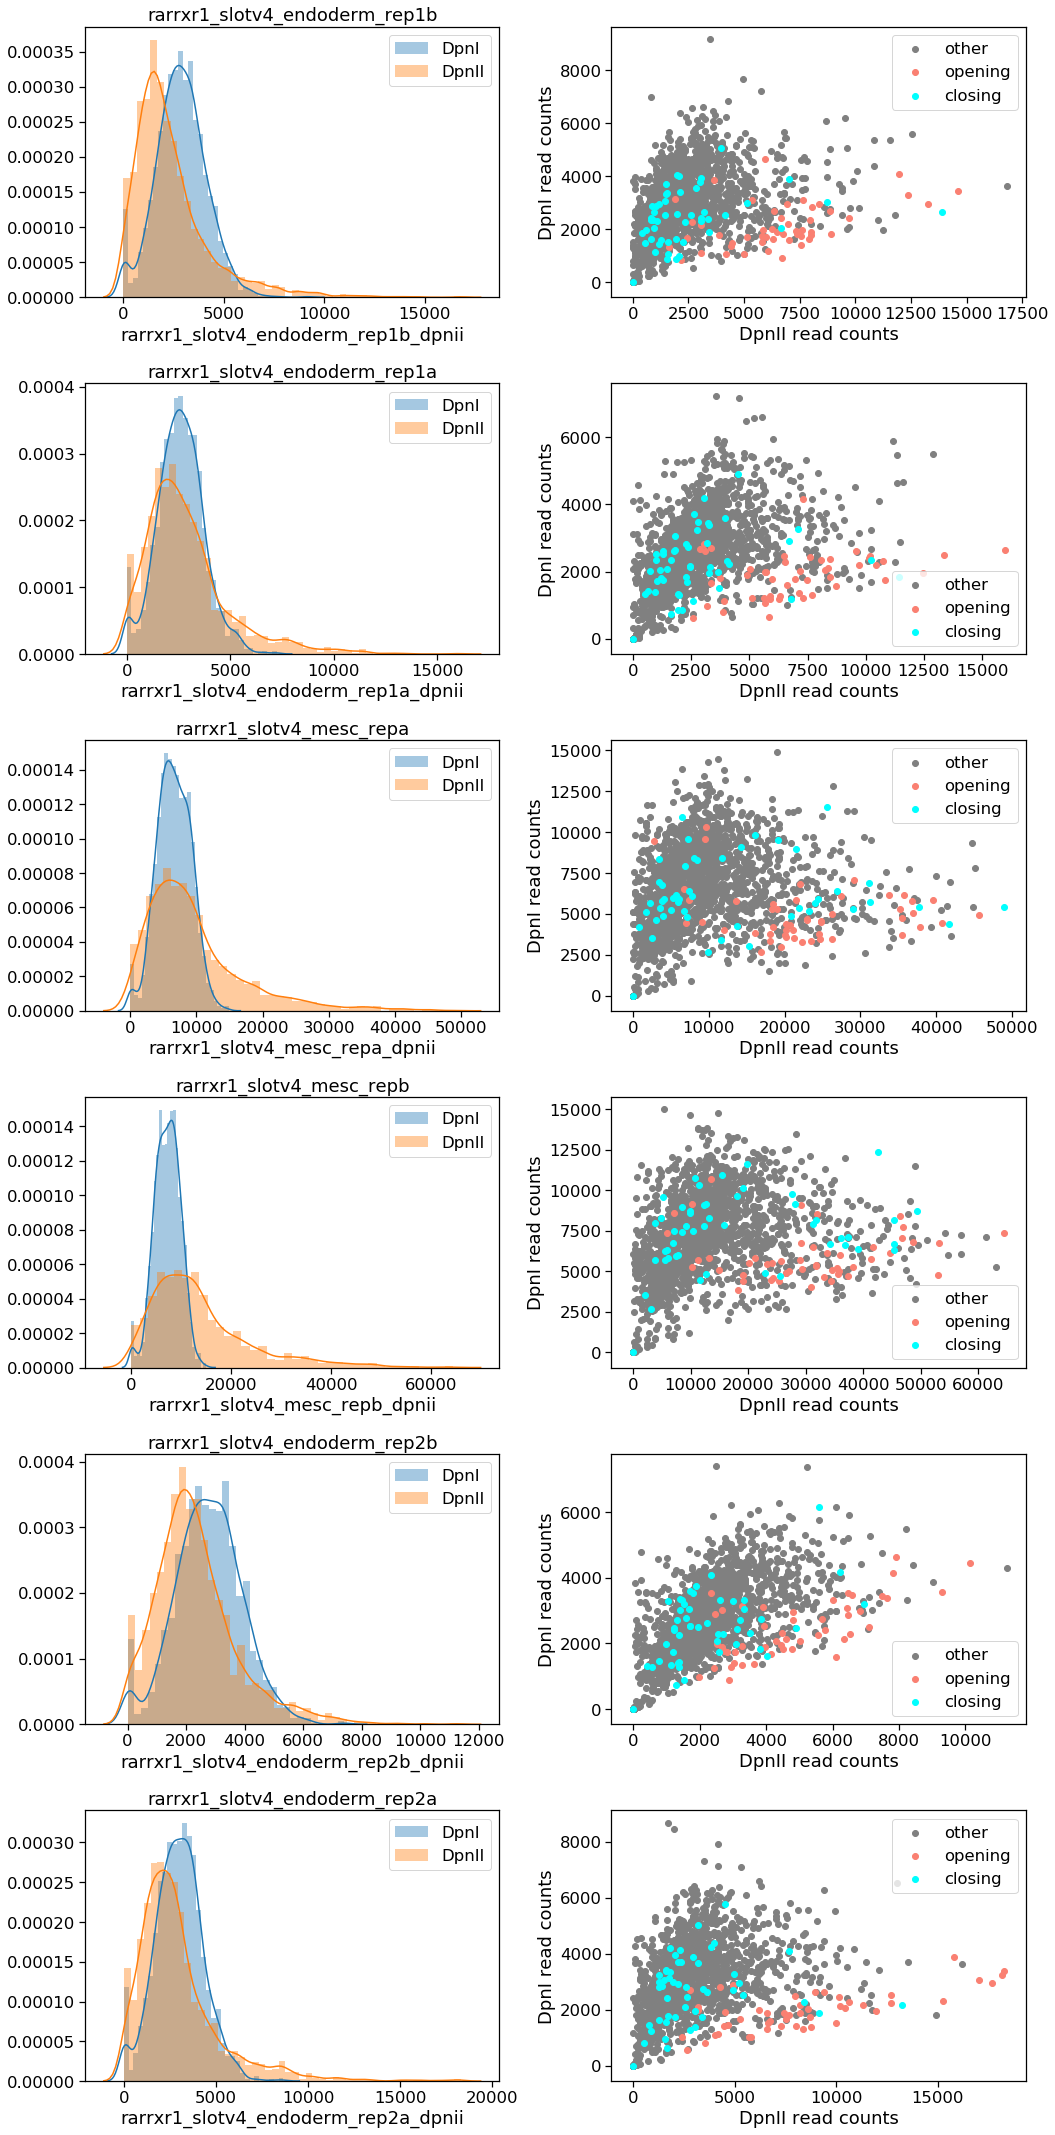

In [4]:
sns.set_context('notebook',font_scale=1.5)
expts = set(['_'.join(c.split('_')[:-1]) for c in df.columns if c != 'tf' and c != 'seq' and c != 'cat'])
i=1
plt.figure(figsize=(15,30))
for expt in expts:
    plt.subplot(len(expts),2,i)
    sns.distplot(df[expt+'_dpni'],label='DpnI')
    sns.distplot(df[expt+'_dpnii'],label='DpnII')
    plt.title(expt)
    plt.tight_layout()
    plt.legend()
    i+=1
    plt.subplot(len(expts),2,i)
    def cat_name(cat):
        if 'CAT' in cat:
            if '1' in cat or '2' in cat:
                return 'opening'
            else:
                return 'closing'
        else:
            return 'other'
    df['cat'] = [cat_name(cat) for cat in df.tf]
    colors={'other':'grey','opening':'salmon','closing':'aqua'}
    for cat in colors.keys():
        plt.scatter(df[df['cat']==cat][expt+'_dpnii'],df[df['cat']==cat][expt+'_dpni'],label=cat,color=colors[cat])
    plt.legend()
    plt.xlabel('DpnII read counts')
    plt.ylabel('DpnI read counts')
    plt.tight_layout()
    i+=1
plt.savefig('plots/read_counts_and_opening_closing.png',dpi=200)

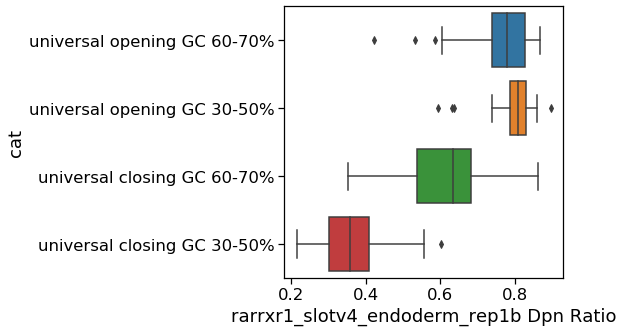

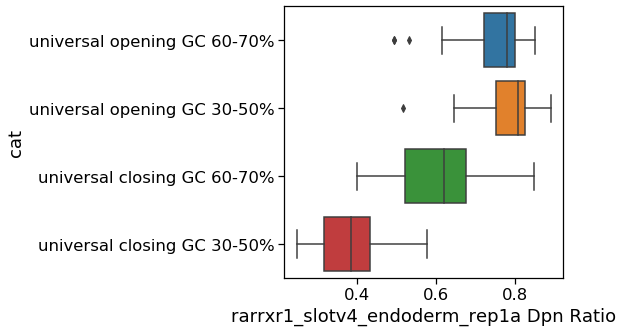

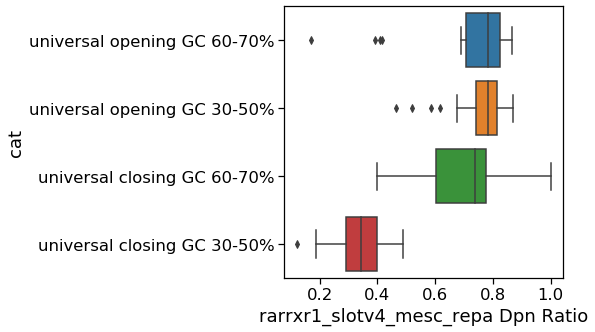

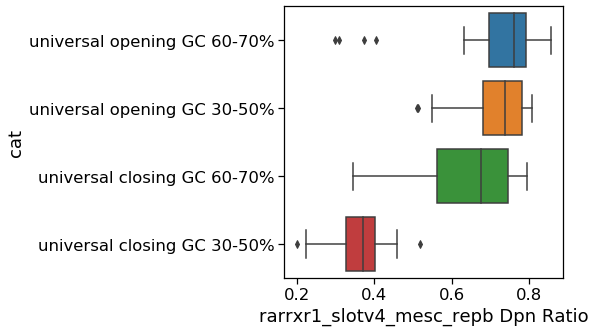

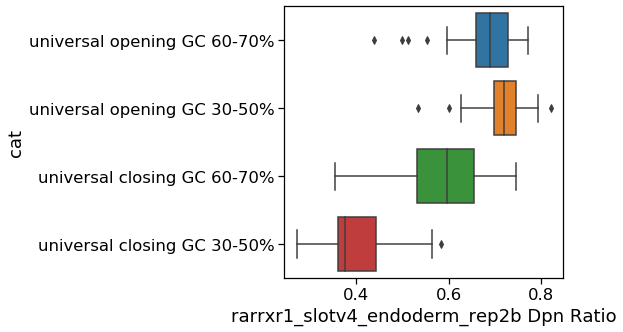

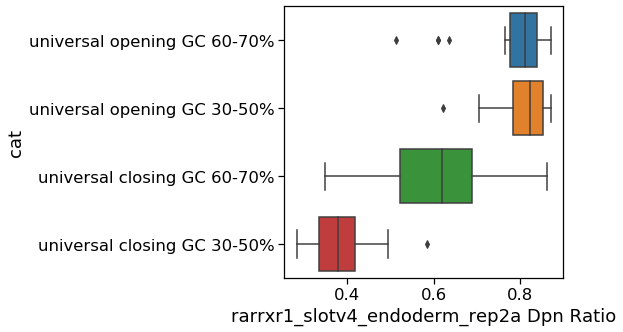

In [5]:
cat2desc = {'CAT1':'universal opening GC 60-70%',
            'CAT2':'universal opening GC 30-50%',
           'CAT3':'universal closing GC 60-70%',
           'CAT4':'universal closing GC 30-50%',
           }
def cat_name(cat):
    if 'CAT' in cat:
        return cat2desc[cat] 
    else:
        return cat
df['cat'] = [cat_name(cat) for cat in df.tf]
for expt in expts:
    df[expt+'_dpnii_norm'] = df[expt+'_dpnii']/(np.sum(df[expt+'_dpnii'])/1000000)
    df[expt+'_dpni_norm'] = df[expt+'_dpni']/(np.sum(df[expt+'_dpni'])/1000000)
    df[expt+' Dpn Ratio'] = df[expt+'_dpnii_norm']/(df[expt+'_dpnii_norm']+df[expt+'_dpni_norm'])
    plt.figure(figsize=(5,5))
    sns.boxplot(y='cat',x=expt+' Dpn Ratio',data=df,order=list(cat2desc.values()))
    plt.show()

In [6]:
df['ES Dpn ratio'] = (df['rarrxr1_slotv4_mesc_repa Dpn Ratio'] +df['rarrxr1_slotv4_mesc_repb Dpn Ratio'])/ 2.0
df['ED Dpn ratio'] = (df['rarrxr1_slotv4_endoderm_rep1a Dpn Ratio'] + df['rarrxr1_slotv4_endoderm_rep1b Dpn Ratio'] + df['rarrxr1_slotv4_endoderm_rep2a Dpn Ratio'] + df['rarrxr1_slotv4_endoderm_rep2b Dpn Ratio'])/ 4.0

data_dpn = pd.merge(df,meta_df[['seq','control','background','distance','filler','ES score','ED score']])
data_dpn.head()

seq     tf  \
0  GACTGTACCGAAGAGACAGCAACTGAGAGTGCCATTGTTTTGGGCT...  sox17   
1  TCCGAGTACGCAGTATGATCACAGGACAGCTCGCCATGCTTCAGGA...  sox17   
2  GAGGTCTGACTTCTGTGTAAAGCCCCGCCCGCCATTGTTTTAAACA...  sox17   
3  GCAGGTGCCAACTATCACCTTGCGTTTCTCGTTGTTAATCGTGAGT...  sox17   
4  CATAAACGCACCTTGTATAATCTATAGATTGCCATTGTTTTTCGAC...  sox17   

   rarrxr1_slotv4_mesc_repa_dpni  rarrxr1_slotv4_mesc_repa_dpnii  \
0                           8880                           10766   
1                           6927                            2403   
2                           4388                           22215   
3                          10237                           11856   
4                           4637                            3356   

   rarrxr1_slotv4_mesc_repb_dpni  rarrxr1_slotv4_mesc_repb_dpnii  \
0                           9916                           19279   
1                           7020                            2678   
2                           5802                           22942   
3                          11064                           21973   
4                           3737                            3374   

   rarrxr1_slotv4_endoderm_rep1a_dpni  rarrxr1_slotv4_endoderm_rep1b_dpni  \
0                                3810                                4603   
1                                1909                                2599   
2                                2281                                1867   
3                                3449                                3082   
4                                2402                                2187   

   rarrxr1_slotv4_endoderm_rep2a_dpni  rarrxr1_slotv4_endoderm_rep2b_dpni  \
0                                4904                                4119   
1                                3020                                3101   
2                                2536                                1835   
3                                4052                                2946   
4                                2362                                2032   

   ...  rarrxr1_slotv4_endoderm_rep2a_dpni_norm  \
0  ...                               848.717492   
1  ...                               522.660446   
2  ...                               438.896321   
3  ...                               701.264942   
4  ...                               408.782772   

   rarrxr1_slotv4_endoderm_rep2a Dpn Ratio  ES Dpn ratio  ED Dpn ratio  \
0                                 0.428870      0.482224      0.478962   
1                                 0.368358      0.181070      0.365725   
2                                 0.682192      0.727828      0.681911   
3                                 0.424432      0.479216      0.458910   
4                                 0.312950      0.328991      0.348327   

     control               background  distance  filler             ES score  \
0      motif            "1470,-,None"         6     N/A  0.47275000511270915   
1  scrambled            "1470,-,None"         6     N/A   0.5924902218383735   
2      motif            "1505,-,None"         6     N/A  0.45349155182067813   
3  scrambled            "1505,-,None"         6     N/A  0.44670208703299025   
4      motif  "1308,scrambled-1,None"         6     N/A  0.41139989523146536   

             ED score  
0  0.5204351973815456  
1  0.5770268332252266  
2  0.4057529381156254  
3  0.5699520865465608  
4  0.3468925858985108  

[5 rows x 41 columns]

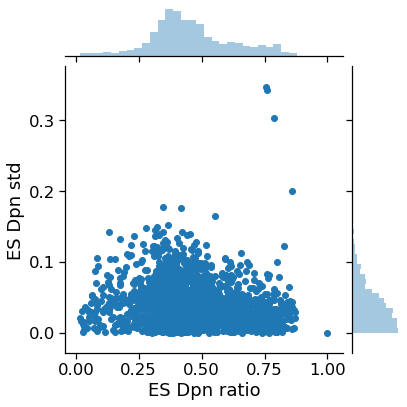

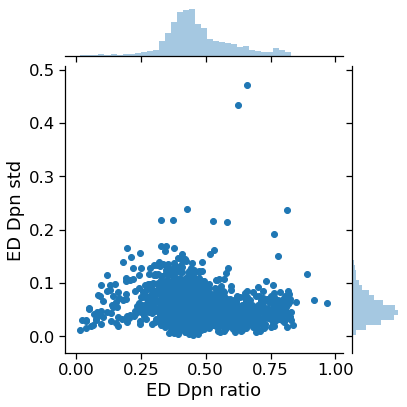

In [7]:
data_dpn['ES Dpn std'] = data_dpn[[c for c in data_dpn.columns if 'Dpn Ratio' in c and 'mesc' in c]].std(axis=1)
data_dpn['ED Dpn std'] = data_dpn[[c for c in data_dpn.columns if 'Dpn Ratio' in c and 'endoderm' in c]].std(axis=1)

sns.jointplot('ES Dpn ratio','ES Dpn std',data=data_dpn) 
sns.jointplot('ED Dpn ratio','ED Dpn std',data=data_dpn) 

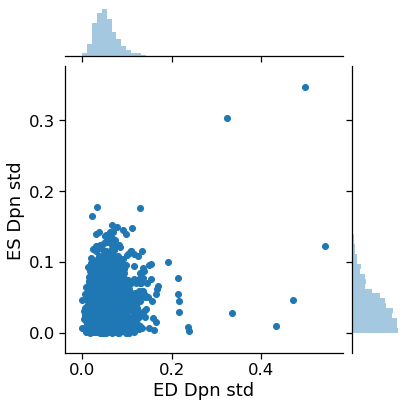

In [8]:
sns.jointplot(x='ED Dpn std',y='ES Dpn std',data=data_dpn)

In [9]:
all_data = pd.melt(data_dpn,id_vars=['seq','cat','background','control','distance','filler'],
                  value_vars=[c for c in data_dpn.columns if 'dpni_norm' in c or 'dpnii_norm' in c])
len(all_data)

23124

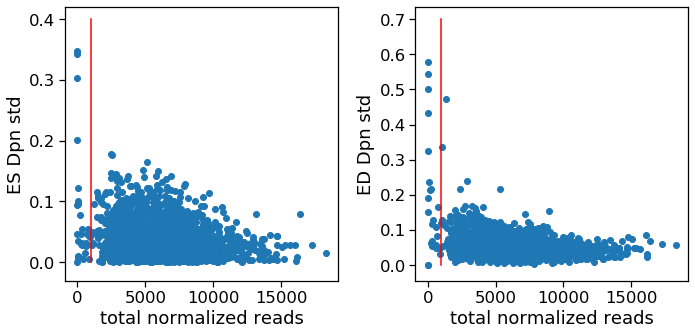

In [10]:
plt.figure(figsize=(10,5))
data_dpn['total normalized reads'] = data_dpn[[c for c in data_dpn.columns if 'dpni_norm' in c or 'dpnii_norm' in c]].sum(axis=1)
plt.subplot(1,2,1)
plt.scatter(x='total normalized reads',y='ES Dpn std',data=data_dpn)
plt.plot([1000,1000],[0.0,0.4],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('ES Dpn std')
plt.tight_layout()
plt.subplot(1,2,2)
data_dpn['total_reads'] = data_dpn[[c for c in data_dpn.columns if 'dpni_norm' in c or 'dpnii_norm' in c]].sum(axis=1)
plt.scatter(x='total normalized reads',y='ED Dpn std',data=data_dpn)
plt.plot([1000,1000],[0.0,0.7],color='r')
plt.xlabel('total normalized reads')
plt.ylabel('ED Dpn std')
plt.tight_layout()
plt.savefig('plots/threshold_2k_library.svg')

In [11]:
#should be same as above
len(data_dpn)*len(set(all_data['variable']))

23124

In [12]:
all_data['replicate'] = [v.split('_dpn')[0] for v in all_data['variable']]
all_data['digest'] = ['dpn'+v.split('_dpn')[1] for v in all_data['variable']]
phrases_both_digest = pd.pivot_table(all_data,index=['seq','cat','background','control','distance','filler','replicate'],
                                    columns='digest',values='value')
len(phrases_both_digest)

11562

In [13]:
#should be same as above
len(set(all_data['replicate']))*len(data_dpn)

11562

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


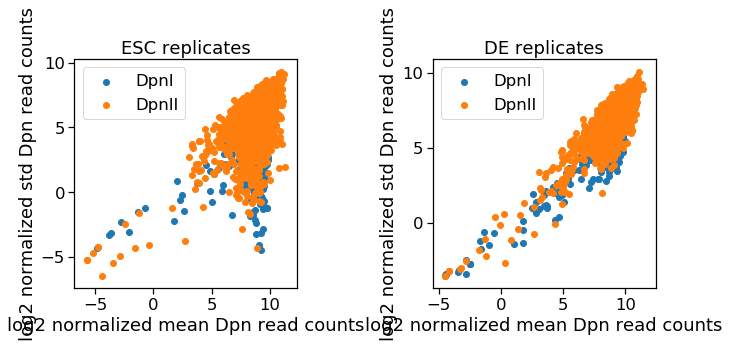

In [14]:
ES_norm_dpni = data_dpn[[c for c in data_dpn.columns if 'dpni_norm' in c and 'mesc' in c]].mean(axis=1)
ES_std_dpni = data_dpn[[c for c in data_dpn.columns if 'dpni_norm' in c and 'mesc' in c]].std(axis=1)
ES_norm_dpnii = data_dpn[[c for c in data_dpn.columns if 'dpnii_norm' in c and 'mesc' in c]].mean(axis=1)
ES_std_dpnii = data_dpn[[c for c in data_dpn.columns if 'dpnii_norm' in c and 'mesc' in c]].std(axis=1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(np.log2(ES_norm_dpni),np.log2(ES_std_dpni),label='DpnI')
plt.scatter(np.log2(ES_norm_dpnii),np.log2(ES_std_dpnii),label='DpnII')
plt.legend()
plt.title('ESC replicates')
plt.xlabel('log2 normalized mean Dpn read counts')
plt.ylabel('log2 normalized std Dpn read counts')
plt.tight_layout()
plt.subplot(1,2,2)
ED_norm_dpni = data_dpn[[c for c in data_dpn.columns if 'dpni_norm' in c and 'endoderm' in c]].mean(axis=1)
ED_std_dpni = data_dpn[[c for c in data_dpn.columns if 'dpni_norm' in c and 'endoderm' in c]].std(axis=1)
ED_norm_dpnii = data_dpn[[c for c in data_dpn.columns if 'dpnii_norm' in c and 'endoderm' in c]].mean(axis=1)
ED_std_dpnii = data_dpn[[c for c in data_dpn.columns if 'dpnii_norm' in c and 'endoderm' in c]].std(axis=1)
plt.scatter(np.log2(ED_norm_dpni),np.log2(ED_std_dpni),label='DpnI')
plt.scatter(np.log2(ED_norm_dpnii),np.log2(ED_std_dpnii),label='DpnII')
plt.legend()
plt.xlabel('log2 normalized mean Dpn read counts')
plt.ylabel('log2 normalized std Dpn read counts')
plt.title('DE replicates')
plt.tight_layout()
plt.show()

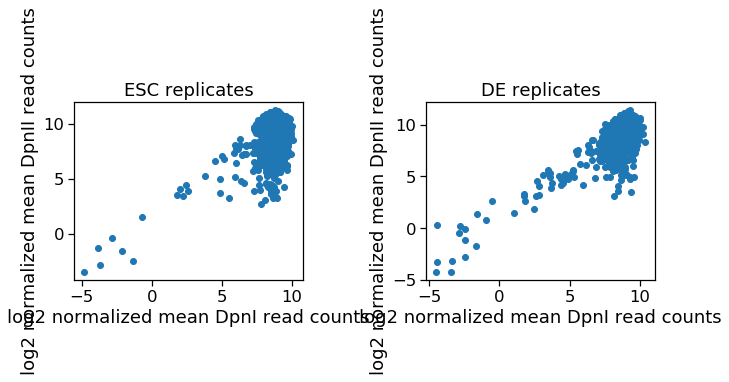

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(np.log2(ES_norm_dpni),np.log2(ES_norm_dpnii))
plt.xlabel('log2 normalized mean DpnI read counts')
plt.ylabel('log2 normalized mean DpnII read counts')
plt.title('ESC replicates')
plt.tight_layout()
plt.subplot(1,2,2)
plt.scatter(np.log2(ED_norm_dpni),np.log2(ED_norm_dpnii))
plt.xlabel('log2 normalized mean DpnI read counts')
plt.ylabel('log2 normalized mean DpnII read counts')
plt.title('DE replicates')
plt.tight_layout()
plt.show()

In [14]:
data_dpn = data_dpn[data_dpn['total normalized reads'] > 1000]
df['ES Dpn ratio'] = (df['rarrxr1_slotv4_mesc_repa Dpn Ratio'] +df['rarrxr1_slotv4_mesc_repb Dpn Ratio'])/ 2.0
df['ED Dpn ratio'] = (df['rarrxr1_slotv4_endoderm_rep1a Dpn Ratio'] + df['rarrxr1_slotv4_endoderm_rep1b Dpn Ratio'] + df['rarrxr1_slotv4_endoderm_rep2a Dpn Ratio'] + df['rarrxr1_slotv4_endoderm_rep2b Dpn Ratio'])/ 4.0


In [17]:
# Tried removing phrases bin each replicate,
# probably better to remove phrases that have high 
# std entirely
'''
confident_phrases = phrases_both_digest[(phrases_both_digest.dpni_norm > 2**-12)|(phrases_both_digest.dpnii_norm > 2**-12)]
len(confident_phrases)
confident_phrases['Dpn ratio'] = confident_phrases['dpnii_norm']/(confident_phrases['dpnii_norm']+confident_phrases['dpni_norm'])
confident_phrases_reps = confident_phrases.pivot_table(index=['seq','cat','background','control','distance','filler'],
                                                      columns=['replicate'],
                                                      values='Dpn ratio')
data_dpn = confident_phrases_reps
data_dpn.reset_index(level=data_dpn.index.names, inplace=True)
'''


"\nconfident_phrases = phrases_both_digest[(phrases_both_digest.dpni_norm > 2**-12)|(phrases_both_digest.dpnii_norm > 2**-12)]\nlen(confident_phrases)\nconfident_phrases['Dpn ratio'] = confident_phrases['dpnii_norm']/(confident_phrases['dpnii_norm']+confident_phrases['dpni_norm'])\nconfident_phrases_reps = confident_phrases.pivot_table(index=['seq','cat','background','control','distance','filler'],\n                                                      columns=['replicate'],\n                                                      values='Dpn ratio')\ndata_dpn = confident_phrases_reps\ndata_dpn.reset_index(level=data_dpn.index.names, inplace=True)\n"

# Do any single motifs open chromatin?

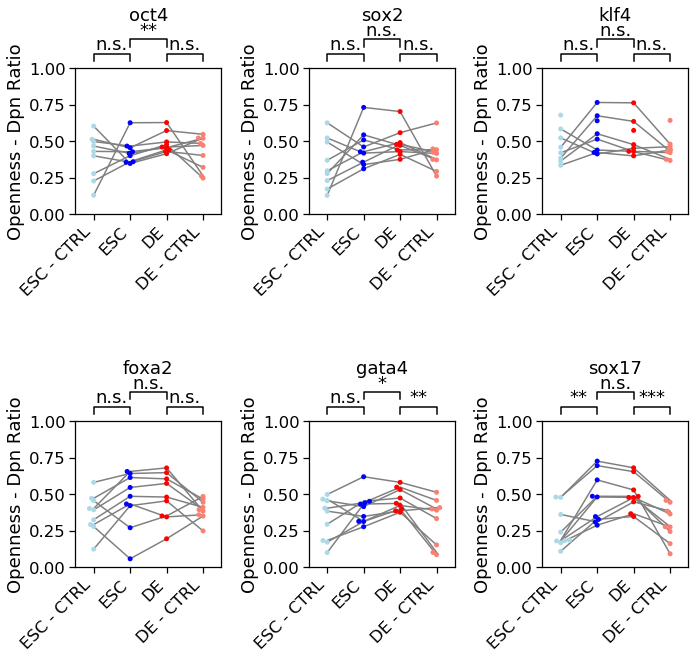

In [13]:
def rename(name):
    newname = ''
    if 'ES' in name:
        newname += 'ESC'
    else:
        newname += 'DE'
    if 'scrambled' in name:
        newname += ' - CTRL'
    return newname
pltind=1
plt.figure(figsize=(10,11))
tfs = ['oct4','sox2','klf4','foxa2','gata4','sox17']
for tf in tfs:
    plt.subplot(3,3,pltind)
    tfkeep = data_dpn[data_dpn['cat'].isin([c for c in set(data_dpn['cat']) 
                                      if ((tf == c))])]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],columns=['control'],
                                 values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','cat','distance','control'],keep_pd,title=tf)
    pltind+=1
    
#plt.show()    
plt.savefig('plots/known_motifs_single_instance.svg',bbox_inches='tight')

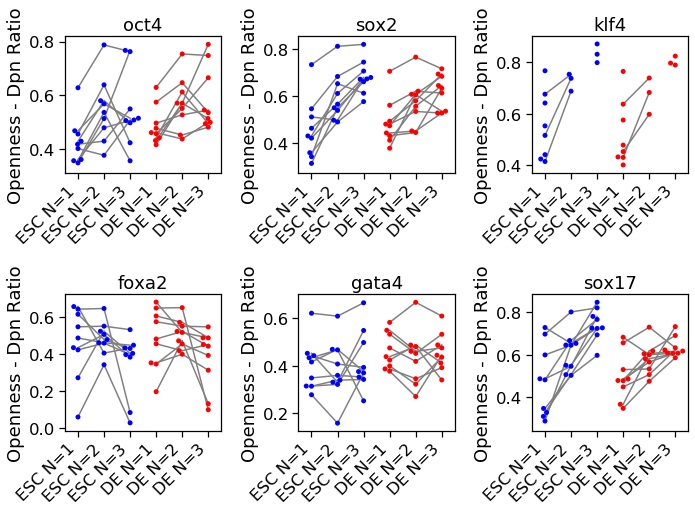

In [14]:
plt.figure(figsize=(10,10))
pltind=1
for tfselect in tfs:
    k2 = data_dpn[data_dpn['cat'].isin([c for c in set(data_dpn['cat']) 
                                          if (tfselect in c)])]
    k2 = k2[k2['control']=='motif']
    k2['nunique'] = [len(set(c.split(','))) for c in k2['cat']]
    k2['nmotifs'] = [len(c.split(',')) for c in k2['cat']]
    k2 = k2[k2['nunique']==1]
    
    k2 = k2[k2['distance']=='6']
    
    k2['gc.content'] = [(s.count('G')+s.count('C'))/float(len(s)) for s in k2.seq]
    k2_melt = pd.melt(k2,id_vars = ['nmotifs','gc.content','seq','background','cat','distance','control'],
                       value_vars = [c for c in k2.columns if 'Dpn ratio' in c])
    #k2_melt = k2_melt[(k2_melt['value'] != 1.0) & (k2_melt['value'] != 0.0)]
    k2_melt['index'] = k2_melt['variable']+'/'+k2_melt['cat']+'/'+k2_melt['distance']
    #k2_melt['index'] = k2_melt['replicate']+'/'+k2_melt['cat']+'/'+k2_melt['distance']
    
    k2_melt['tf'] = [t.split(' ')[0] for t in k2_melt['variable']]
    #k2_melt['tf'] = [t.split(' ')[0] for t in k2_melt['replicate']]
    
    cpal = {'ESC N=1':'blue',
           'ESC N=2':'blue',
           'ESC N=3':'blue',
           'DE N=1':'red',
           'DE N=2':'red',
           'DE N=3':'red'}
    namemap = {'ES':'ESC','ED':'DE'}
    k2_melt['rename'] = [namemap[t] for t in k2_melt['tf']]
    k2_melt['name']=k2_melt['rename']+' N='+k2_melt['nmotifs'].astype(str)
    
    plt.subplot(3,3,pltind)
    sns.swarmplot(x='name',y='value',data=k2_melt,color='black',palette=cpal,
                 order=['ESC N=1','ESC N=2','ESC N=3',
                       'DE N=1','DE N=2','DE N=3'])
    motif_bg  = pd.pivot_table(data=k2,index='background',
                                    columns=['nmotifs'],
                                    values=['ES Dpn ratio','ED Dpn ratio'])
    
    for i in range(len(motif_bg)):
        if not np.any(np.isnan(motif_bg['ES Dpn ratio'].values[i,:2])):
            plt.plot([0,1],
                motif_bg['ES Dpn ratio'].values[i,:2],color='grey')
        if not np.any(np.isnan(motif_bg['ES Dpn ratio'].values[i,1:])): 
            plt.plot([1,2],
                    motif_bg['ES Dpn ratio'].values[i,1:],color='grey')
        if not np.any(np.isnan(motif_bg['ED Dpn ratio'].values[i,:2])):
            plt.plot([3,4], 
                    motif_bg['ED Dpn ratio'].values[i,:2],color='grey')
        if not np.any(np.isnan(motif_bg['ED Dpn ratio'].values[i,1:])):
            plt.plot([4,5], 
                    motif_bg['ED Dpn ratio'].values[i,1:],color='grey')
    #break
    plt.xticks(rotation=45,ha='right')
    plt.title(tfselect)
    pltind+=1
    plt.xlabel('')
    plt.ylabel('Openness - Dpn Ratio')
    plt.tight_layout()
plt.savefig('plots/number_motifs_phrases.svg',bbox_inches='tight')

# Does distance matter?

In [15]:
keep = data_dpn[data_dpn['cat'].isin([c for c in set(data_dpn['cat']) 
                                      if (('oct4' in c) or ('sox2' in c) or ('klf4' in c)
                                         or ('sox17' in c) or ('gata4' in c) or ('foxa2' in c))])]
keep = keep[[len(d.split(','))==2 for d in keep['cat']]]
keep.head()

seq           tf  \
54  GACTGTACCGAAGAGACAGCAAGCCATTGTTTTGACTACGCAGATA...  sox17,gata4   
55  CGAGCCGGTACGTGCAAGGCATAGATAAAGCGGTCAAGTGGTCGAA...  sox17,gata4   
56  GAGGTCTGACTTCTGTGTAAAGGCCATTGTTTTCTCCCTGCAGATA...  sox17,gata4   
57  ACATACTTGTATGTCTAACGCGTGAGTGTTCCTTCCGGGGCATACT...  sox17,gata4   
58  CATAAACGCACCTTGTATAATCGCCATTGTTTTGTAACAGCAGATA...  sox17,gata4   

    rarrxr1_slotv4_mesc_repa_dpni  rarrxr1_slotv4_mesc_repa_dpnii  \
54                          11077                           14310   
55                           6530                           10239   
56                          11207                           14419   
57                          10093                            7351   
58                           5522                            6231   

    rarrxr1_slotv4_mesc_repb_dpni  rarrxr1_slotv4_mesc_repb_dpnii  \
54                           8594                           17902   
55                           6223                           20706   
56                          13302                           18105   
57                          11891                           12704   
58                           6076                            5890   

    rarrxr1_slotv4_endoderm_rep1a_dpni  rarrxr1_slotv4_endoderm_rep1b_dpni  \
54                                3218                                3846   
55                                2562                                2116   
56                                3565                                4601   
57                                3595                                3470   
58                                2049                                2682   

    rarrxr1_slotv4_endoderm_rep2a_dpni  rarrxr1_slotv4_endoderm_rep2b_dpni  \
54                                3820                                3958   
55                                2490                                2661   
56                                4500                                4890   
57                                5541                                5135   
58                                2434                                1789   

    ...    control               background  distance  filler  \
54  ...      motif            "1470,-,None"         6     N/A   
55  ...  scrambled            "1470,-,None"         6     N/A   
56  ...      motif            "1505,-,None"         6     N/A   
57  ...  scrambled            "1505,-,None"         6     N/A   
58  ...      motif  "1308,scrambled-1,None"         6     N/A   

               ES score             ED score  ES Dpn std  ED Dpn std  \
54  0.47942296279022034  0.47539383923400824    0.038583    0.058525   
55   0.5986419049714461   0.6309624310326863    0.084498    0.089492   
56  0.37796878621551805   0.2712546979340302    0.035429    0.028461   
57   0.3682000897382962   0.3856805182880387    0.019881    0.050649   
58   0.3172950278851184  0.32903889096520766    0.068840    0.106414   

    total normalized reads   total_reads  
54             9040.281907   9040.281907  
55             5646.301505   5646.301505  
56            10540.978803  10540.978803  
57             8012.131925   8012.131925  
58             4368.033411   4368.033411  

[5 rows x 45 columns]

In [16]:
wilcoxon_tests = {}
ttest_tests = {}
all_cats = list(set(keep['cat']))

for cat in all_cats:
    for distance in set(keep['distance']):
        keep_cat = keep[(keep['cat']==cat)&(keep['control']=='motif')&(keep['distance']==distance)]
        keep_pd = keep_cat.pivot_table(index=['background','distance'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
        if len(keep_cat) > 0:
            wilcoxon_tests[cat+'-'+distance] = wilcoxon(keep_pd['ES Dpn ratio'],keep_pd['ED Dpn ratio'])
            ttest_tests[cat+'-'+distance] = ttest_rel(keep_pd['ES Dpn ratio'],keep_pd['ED Dpn ratio'])
    
tests = wilcoxon_tests.keys()
wilcoxon_pvals = np.array([wilcoxon_tests[cat][1] for cat in tests])
ttest_pvals = np.array([ttest_tests[cat][1] for cat in tests])
wilcoxon_true,_,_,_ = multipletests(wilcoxon_pvals,method='fdr_bh')
ttest_true,_,_,_ = multipletests(ttest_pvals,method='fdr_bh')
diff_sig_cats = [cat for i,cat in enumerate(tests) if ttest_true[i] and wilcoxon_true[i]]

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [17]:
#no significant distance
diff_sig_cats

[]

# Statistically test each paired and cell type  for differential accessibility

In [27]:
keep = data_dpn[data_dpn['cat'].isin([c for c in set(data_dpn['cat']) 
                                      if (('oct4' in c) or ('sox2' in c) or ('klf4' in c)
                                         or ('sox17' in c) or ('gata4' in c) or ('foxa2' in c))])]

wilcoxon_tests = {}
ttest_tests = {}
all_cats = list(set(keep['cat']))
for cat in all_cats:
    keep_motif = keep[(keep['cat']==cat)&(keep['control']=='motif')]
    def contains_motifs(df_cat):
        data = cat.split(',')
        for tf in data:
            if tf not in df_cat:
                return False
        return True
    keep_ctrl = keep[keep['cat']==cat]
    keep_ctrl = keep_ctrl[keep_ctrl['control']=='scrambled']
    keep_cat = pd.concat([keep_ctrl,keep_motif])
    keep_pd = keep_cat.pivot_table(index=['background','distance'],columns=['control'],
                                   values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    es_scram = wilcoxon(keep_pd['ES Dpn ratio'].motif,keep_pd['ES Dpn ratio'].scrambled)
    ed_scram = wilcoxon(keep_pd['ED Dpn ratio'].motif,keep_pd['ED Dpn ratio'].scrambled)
    wilcoxon_tests[cat] = min(es_scram[1],ed_scram[1])
    es_scram = ttest_rel(keep_pd['ES Dpn ratio'].motif,keep_pd['ES Dpn ratio'].scrambled)
    ed_scram = ttest_rel(keep_pd['ED Dpn ratio'].motif,keep_pd['ED Dpn ratio'].scrambled)
    ttest_tests[cat] = min(es_scram[1],ed_scram[1])
wilcoxon_pvals = np.array([wilcoxon_tests[cat] for cat in all_cats])
ttest_pvals = np.array([ttest_tests[cat] for cat in all_cats])
wilcoxon_true,_,_,_ = multipletests(wilcoxon_pvals,method='fdr_bh')
ttest_true,_,_,_ = multipletests(ttest_pvals,method='fdr_bh')
scram_sig_cats = [cat for i,cat in enumerate(all_cats) if ttest_true[i] and wilcoxon_true[i]]

sox17,foxa2,gata4 5.073396946721048 3.7794443154865607 0.0009609556552523865
klf4,klf4 6.89827981256769 6.4819333061583855 0.00012474475773719716
sox2,klf4 7.6738634129810235 6.921213731416825 3.5163932449974516e-06
sox17,sox17 5.538478524548529 5.277692715069931 3.6100962161357135e-05
sox17,sox17,sox17 5.597882395065243 7.246505751871701 8.835344833307357e-05
oct4,sox2,klf4 7.410252497351596 9.60392063922465 1.14681618033939e-05
gata4,foxa2,sox17 3.090366439363978 3.201533171017274 0.01258332517383031
sox17,gata4 0.742719320414307 2.91030844229965 0.00974721689362507
gata4,foxa2 3.5661567284773508 4.793503098386057 0.0001989450720058954
foxa2,sox17,gata4 3.994788029061661 5.770646797971353 0.00041897287876648833
foxa2,sox17 5.386429145513101 5.452992947142169 4.29613600757052e-05
oct4,klf4 5.915527314925105 4.556659989596049 5.104328808596684e-05
oct4,klf4,sox2 10.635276531173893 7.936787696238136 1.4234804358969218e-05
foxa2,gata4 3.8405164582607108 5.175053757269126 7.60984492130283

In [25]:
len(scram_sig_cats)
print(len([c for c in scram_sig_cats if len(c.split(','))==1]),'/',len([c for c in all_cats if len(c.split(','))==1]))
print(len([c for c in scram_sig_cats if len(c.split(','))==2]),'/',len([c for c in all_cats if len(c.split(','))==2]))
print(len([c for c in scram_sig_cats]),'/',len([c for c in all_cats]))

2 / 6
17 / 18
35 / 42


In [18]:
keep = data_dpn[data_dpn['cat'].isin([c for c in set(data_dpn['cat']) 
                                      if (('oct4' in c) or ('sox2' in c) or ('klf4' in c)
                                         or ('sox17' in c) or ('gata4' in c) or ('foxa2' in c))])]

wilcoxon_tests = {}
ttest_tests = {}
all_cats = list(set(keep['cat']))
for cat in all_cats:
    keep_cat = keep[(keep['cat']==cat)&(keep['control']=='motif')]
    keep_pd = keep_cat.pivot_table(index=['background','distance'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    wilcoxon_tests[cat] = wilcoxon(keep_pd['ES Dpn ratio'],keep_pd['ED Dpn ratio'])
    ttest_tests[cat] = ttest_rel(keep_pd['ES Dpn ratio'],keep_pd['ED Dpn ratio'])
    
wilcoxon_pvals = np.array([wilcoxon_tests[cat][1] for cat in all_cats])
ttest_pvals = np.array([ttest_tests[cat][1] for cat in all_cats])
wilcoxon_true,_,_,_ = multipletests(wilcoxon_pvals,method='fdr_bh')
ttest_true,_,_,_ = multipletests(ttest_pvals,method='fdr_bh')
diff_sig_cats = [cat for i,cat in enumerate(all_cats) if ttest_true[i] and wilcoxon_true[i]]

In [19]:
for cat in diff_sig_cats:
    print(cat,ttest_tests[cat])

sox17,gata4 Ttest_relResult(statistic=-3.605081859556048, pvalue=0.0021846740166647973)
oct4,klf4 Ttest_relResult(statistic=3.738806050431921, pvalue=0.002479757770889537)
sox2,sox2 Ttest_relResult(statistic=2.7690551110601143, pvalue=0.013132403543886338)
sox17,sox17 Ttest_relResult(statistic=3.3105666170095347, pvalue=0.004134682137004103)
oct4,klf4,sox2 Ttest_relResult(statistic=4.716142057664621, pvalue=0.0021672789107486635)
oct4,sox2,klf4 Ttest_relResult(statistic=5.46693916290282, pvalue=0.0005966064877254522)
gata4,foxa2 Ttest_relResult(statistic=-2.626024212505317, pvalue=0.0176999875396792)
sox17,sox17,sox17 Ttest_relResult(statistic=5.7883896925324265, pvalue=0.00041056460090164266)
klf4,sox2 Ttest_relResult(statistic=3.2637057272931407, pvalue=0.004878248799251642)
klf4,sox2,oct4 Ttest_relResult(statistic=3.372396477439145, pvalue=0.009750885037183)
sox2,klf4,oct4 Ttest_relResult(statistic=3.4323041668526377, pvalue=0.010950913069938784)
foxa2,gata4 Ttest_relResult(statisti

In [20]:
len(diff_sig_cats)

17

In [21]:
scram_wilcoxon_tests = {}
scram_ttest_tests = {}
for cat in diff_sig_cats:
    keep_motif = keep[(keep['cat']==cat)&(keep['control']=='motif')]
    def contains_motifs(df_cat):
        data = cat.split(',')
        for tf in data:
            if tf not in df_cat:
                return False
        return True
    keep_ctrl = keep[keep['cat']==cat]
    keep_ctrl = keep_ctrl[keep_ctrl['control']=='scrambled']
    keep_cat = pd.concat([keep_ctrl,keep_motif])
    keep_pd = keep_cat.pivot_table(index=['background','distance'],columns=['control'],
                                   values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    es_scram = wilcoxon(keep_pd['ES Dpn ratio'].motif,keep_pd['ES Dpn ratio'].scrambled)
    ed_scram = wilcoxon(keep_pd['ED Dpn ratio'].motif,keep_pd['ED Dpn ratio'].scrambled)
    if es_scram[1] < ed_scram[1]:
        scram_wilcoxon_tests[cat] = es_scram
    else:
        scram_wilcoxon_tests[cat] = ed_scram
    es_scram = ttest_rel(keep_pd['ES Dpn ratio'].motif,keep_pd['ES Dpn ratio'].scrambled)
    ed_scram = ttest_rel(keep_pd['ED Dpn ratio'].motif,keep_pd['ED Dpn ratio'].scrambled)
    if es_scram[1] < ed_scram[1]:
        scram_ttest_tests[cat] = es_scram
    else:
        scram_ttest_tests[cat] = ed_scram
wilcoxon_pvals = np.array([scram_wilcoxon_tests[cat][1] for cat in diff_sig_cats])
ttest_pvals = np.array([scram_ttest_tests[cat][1] for cat in diff_sig_cats])

wilcoxon_true,_,_,_ = multipletests(wilcoxon_pvals,method='fdr_bh')
ttest_true,_,_,_ = multipletests(ttest_pvals,method='fdr_bh')
scram_diff_sig_cats = [cat for i,cat in enumerate(diff_sig_cats) if ttest_true[i] and wilcoxon_true[i]]
scram_diff_sig_ordered = sorted(scram_diff_sig_cats,key=lambda x:ttest_tests[x][1])

In [22]:
print(len(scram_diff_sig_cats),len(all_cats))

15 42


In [23]:
print(len([c for c in all_cats if 'oct4' in c and 'sox2' in c and 'klf4' in c]))
print(len([c for c in scram_diff_sig_cats if 'oct4' in c and 'sox2' in c and 'klf4' in c]))

6
4


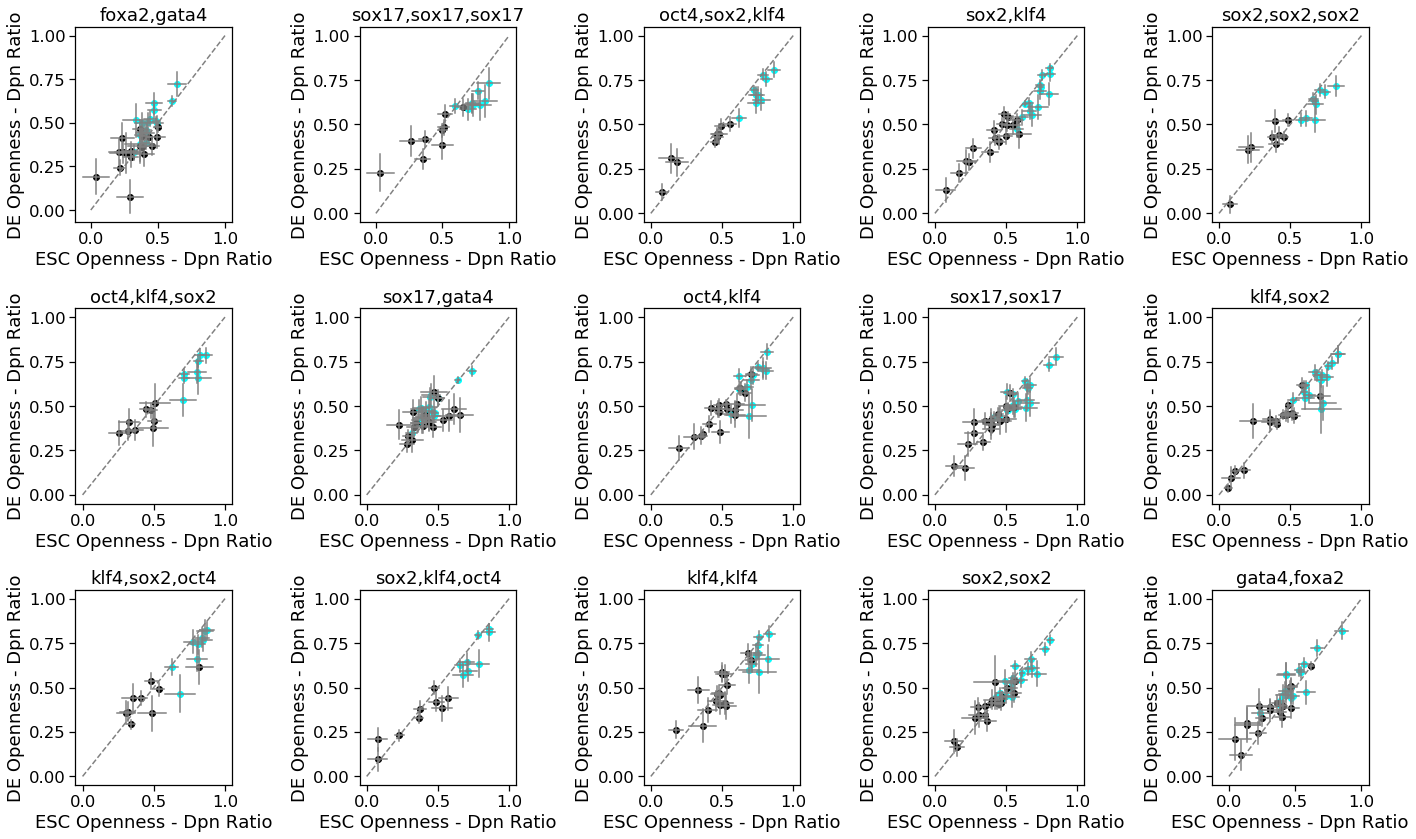

In [24]:
pltind = 1
plt.figure(figsize=(20,12))
for cat in scram_diff_sig_ordered:
    plt.subplot(3,5,pltind)
    tfkeep = data_dpn[data_dpn['cat']==cat]
    plot_bar_scatter(tfkeep,cat)
    pltind += 1
plt.savefig('plots/differentially_significant_with_CI.svg')

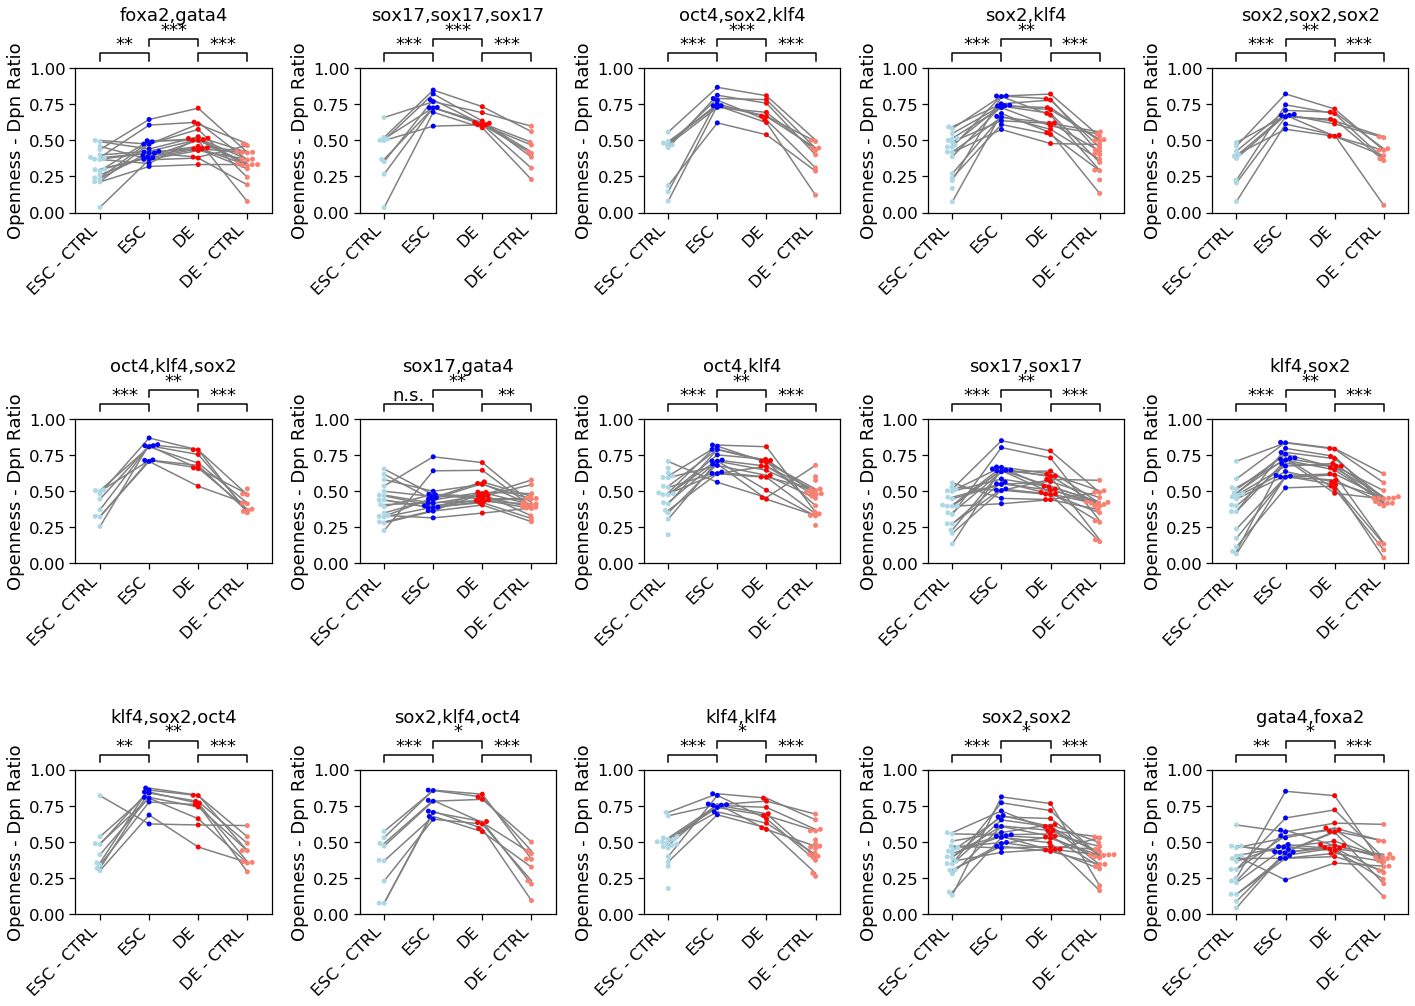

In [25]:
plt.figure(figsize=(20,12))
pltind=1
for cat in scram_diff_sig_ordered:
    plt.subplot(3,5,pltind)
    tfkeep = data_dpn[data_dpn['cat']==cat]        
    keep_pd = tfkeep.pivot_table(index=['background','distance'],columns=['control'],
                                   values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','cat','distance','control'],keep_pd,title=cat)    
    pltind+=1
    
plt.savefig('plots/differentially_significant_combinations.svg',bbox_inches='tight')

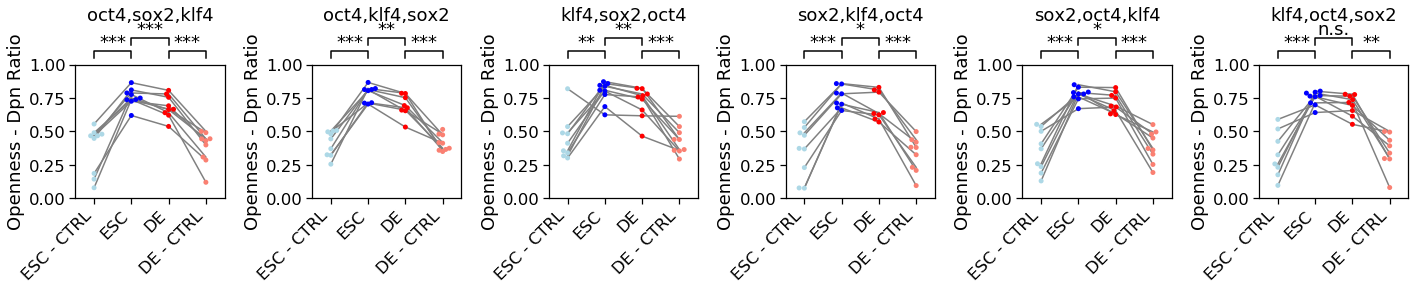

In [26]:
plt.figure(figsize=(20,3))
pltind=1
for cat in ['oct4,sox2,klf4','oct4,klf4,sox2','klf4,sox2,oct4','sox2,klf4,oct4','sox2,oct4,klf4','klf4,oct4,sox2']:
    plt.subplot(1,6,pltind)
    tfkeep = data_dpn[data_dpn['cat']==cat]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','cat','distance','control'],keep_pd,title=cat)    
    pltind+=1    
plt.savefig('plots/OSK_combinations.svg',bbox_inches='tight')

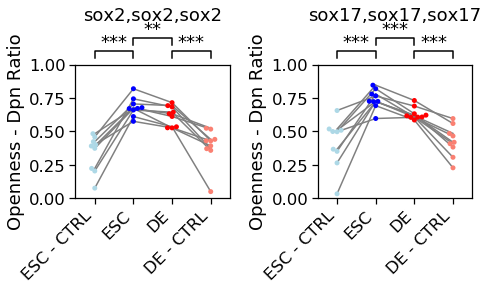

In [27]:
plt.figure(figsize=(7,3))
pltind=1
for cat in ['sox2,sox2,sox2','sox17,sox17,sox17']:
    plt.subplot(1,2,pltind)
    tfkeep = data_dpn[data_dpn['cat']==cat]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','cat','distance','control'],keep_pd,title=cat)
    pltind+=1
    
plt.savefig('plots/sox_homotypic_combinations.svg',bbox_inches='tight')

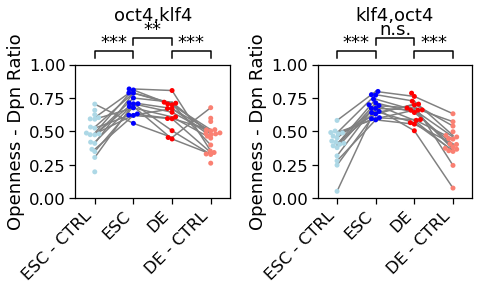

In [83]:
plt.figure(figsize=(7,3))
pltind=1

for cat in ['oct4,klf4','klf4,oct4']:
    plt.subplot(1,2,pltind)
    tfkeep = data_dpn[data_dpn['cat']==cat]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','cat','distance','control'],keep_pd,title=cat)
    pltind += 1
plt.savefig('plots/oct_klf4_combinations.svg',bbox_inches='tight')

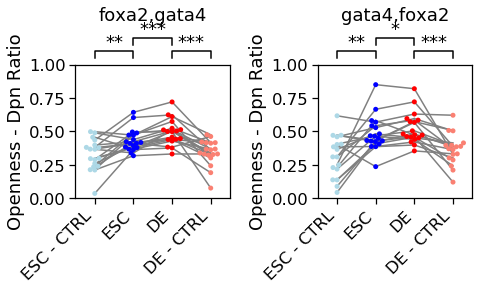

In [74]:
plt.figure(figsize=(7,3))
pltind=1

cat2name={'foxa2,gata4':'Oct4,Klf4','klf4,oct4':'Klf4,Oct4'}
for cat in [c for c in all_cats if 'foxa2' in c and 'gata4' in c and 'sox17' not in c]:
    plt.subplot(1,2,pltind)
    tfkeep = data_dpn[data_dpn['cat']==cat]

    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','cat','distance','control'],keep_pd,title=cat)
    pltind += 1
plt.savefig('plots/fox_gata_combinations.svg',bbox_inches='tight')

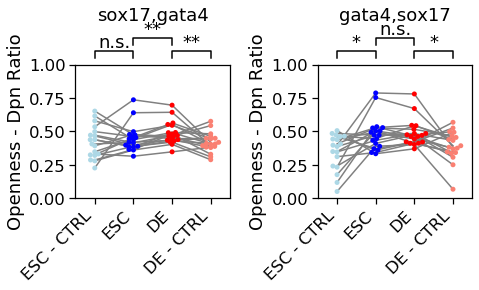

In [82]:
plt.figure(figsize=(7,3))
pltind=1
for cat in ['sox17,gata4','gata4,sox17']:
    plt.subplot(1,2,pltind)
    tfkeep = data_dpn[data_dpn['cat']==cat]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','cat','distance','control'],keep_pd,title=cat)
    pltind += 1

plt.savefig('plots/sox_gata_combinations.svg',bbox_inches='tight')

# Test linear model on all data

(2768, 17)


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

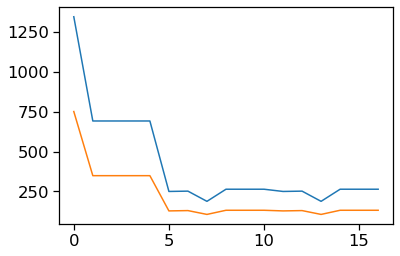

In [14]:
keep = data_dpn[data_dpn['cat'].isin([c for c in set(data_dpn['cat']) 
                                      if (('oct4' in c) or ('sox2' in c) or ('klf4' in c)
                                         or ('sox17' in c) or ('gata4' in c) or ('foxa2' in c))])]
keep['gc.content'] = [(s.count('G')+s.count('C'))/float(len(s)) for s in keep.seq]
keep['nmotifs'] = [len(c.split(',')) for c in keep['cat']]
keep['nunique'] = [len(set(c.split(','))) for c in keep['cat']]
#keep = keep[keep['nmotifs']==1]
keep_melt = pd.melt(keep,id_vars = ['gc.content','seq','background','cat','control','nmotifs','nunique'],
                   value_vars = ['rarrxr1_slotv4_mesc_repa Dpn Ratio',
                                 'rarrxr1_slotv4_endoderm_rep1b Dpn Ratio',
                                'rarrxr1_slotv4_endoderm_rep2b Dpn Ratio', 
                                 'rarrxr1_slotv4_mesc_repb Dpn Ratio']).dropna()
#keep_melt = keep
keep_melt['celltype'] = [v.split('_')[2] for v in keep_melt.variable]
reps = list(set(keep_melt['variable']))
celltypes = ['mesc','endoderm']#list(set(keep_melt['celltype']))
tfs = ['oct4','sox2','klf4','foxa2','gata4','sox17']#list(set(keep_melt['cat']))
test_bgs = ['"1470,scrambled-2,None"',
             '"1470,scrambled-5,None"',
             '"1505,scrambled-5,None"']

train_data = keep_melt[~keep_melt['background'].isin(test_bgs)]
test_data = keep_melt[keep_melt['background'].isin(test_bgs)]
train_exog = np.zeros((len(train_data),1+len(reps)+len(celltypes)*len(tfs)))
test_exog = np.zeros((len(test_data),1+len(reps)+len(celltypes)*len(tfs)))
print(train_exog.shape)
#set Y
test_endog = test_data['value']
train_endog = train_data['value']

#set X
start=0
train_exog[:,start] = train_data['gc.content']
test_exog[:,start] = test_data['gc.content']
start += 1

for j,rep in enumerate(reps):
    train_exog[:,start+j] = (train_data['variable']==rep)
    test_exog[:,start+j] = (test_data['variable']==rep)
start += len(reps)

for i,ct in enumerate(celltypes):
    for j,tf in enumerate(tfs):
        def count_tfs(cat):
            data=cat.split(',')
            if tf in data:
                return data.count(tf)
            else:
                return 0
        mask = (train_data['celltype']==ct)*(train_data['control']=='motif')
        tf_counts = np.array([count_tfs(cat) for cat in train_data.cat])
        train_exog[:,start+j] = tf_counts*mask    
        mask = (test_data['celltype']==ct)*(test_data['control']=='motif')
        tf_counts = np.array([count_tfs(cat) for cat in test_data.cat])
        test_exog[:,start+j] = tf_counts*mask    
    start += len(tfs)
plt.plot(np.sum(train_exog,axis=0))
plt.plot(np.sum(test_exog,axis=0))

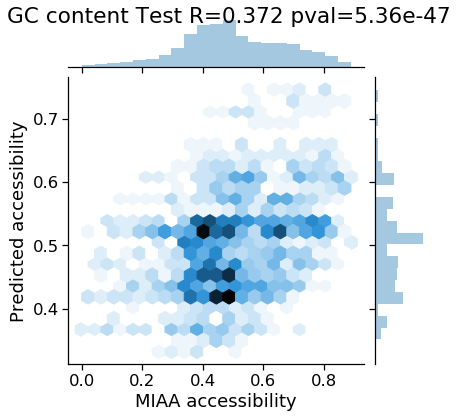

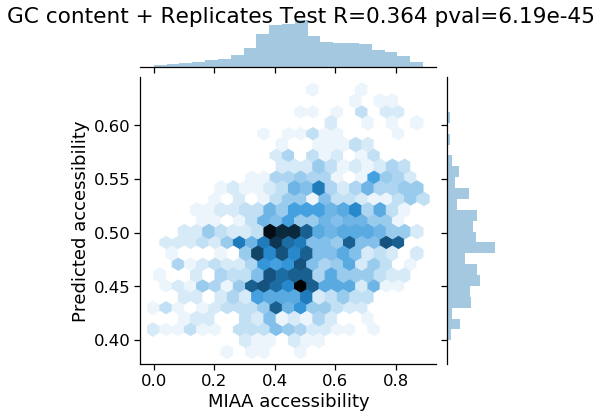

In [15]:
train_gc = np.zeros((train_exog.shape[0],1))
train_gc[:,0] = train_exog[:,0]
test_gc = np.zeros((test_exog.shape[0],1))
test_gc[:,0] = test_exog[:,0]
result = OLS(train_endog,train_gc).fit()
pred = result.predict(test_gc)
h= sns.jointplot(test_endog,pred,kind='hex')
pcor = pearsonr(test_endog,pred)
plt.suptitle('GC content Test R='+str(round(pcor[0],3))+' pval='+str.format('{0:.3g}', pcor[1]))
h.ax_joint.set_xlabel('MIAA accessibility')
h.ax_joint.set_ylabel('Predicted accessibility')
plt.savefig('plots/OSK_FGS_model_GC_only.svg')

train_rep = np.zeros((train_exog.shape[0],1+len(reps)))
train_rep[:,:(1+len(reps))] = train_exog[:,:(1+len(reps))]
test_rep = np.zeros((test_exog.shape[0],1+len(reps)))
test_rep[:,:(1+len(reps))] = test_exog[:,:(1+len(reps))]
result = OLS(train_endog,train_rep).fit()
pred = result.predict(test_rep)
h= sns.jointplot(test_endog,pred,kind='hex')
pcor = pearsonr(test_endog,pred)
plt.suptitle('GC content + Replicates Test R='+str(round(pcor[0],3))+' pval='+str.format('{0:.3g}', pcor[1]))
h.ax_joint.set_xlabel('MIAA accessibility')
h.ax_joint.set_ylabel('Predicted accessibility')
plt.savefig('plots/OSK_FGS_model_GC-reps_only.svg')

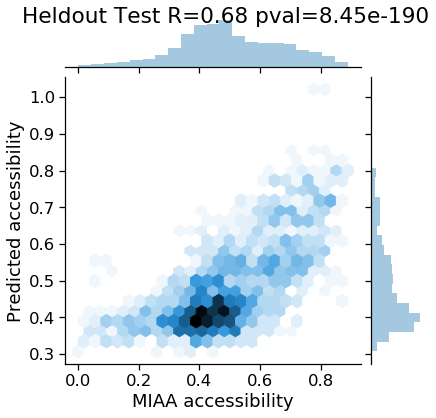

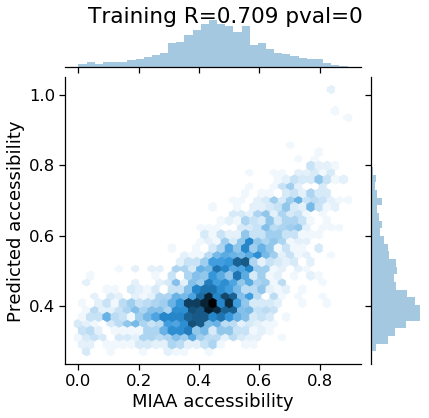

In [16]:
result = OLS(train_endog,train_exog).fit()
pred = result.predict(test_exog)
h= sns.jointplot(test_endog,pred,kind='hex')
pcor = pearsonr(test_endog,pred)
plt.suptitle('Heldout Test R='+str(round(pcor[0],3))+' pval='+str.format('{0:.3g}', pcor[1]))
h.ax_joint.set_xlabel('MIAA accessibility')
h.ax_joint.set_ylabel('Predicted accessibility')
plt.savefig('plots/OSK_FGS_model_test.svg')
pred = result.predict(train_exog)
h = sns.jointplot(train_endog,pred,kind='hex')
pcor = pearsonr(train_endog,pred)
plt.suptitle('Training R='+str(round(pcor[0],3))+' pval='+str.format('{0:.3g}', pcor[1]))
h.ax_joint.set_xlabel('MIAA accessibility')
h.ax_joint.set_ylabel('Predicted accessibility')
plt.savefig('plots/OSK_FGS_model_train.svg')

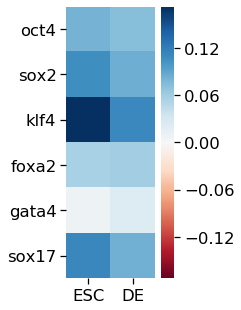

In [17]:
plt.figure(figsize=(2,5))
motif_params = result.params[(1+len(reps)):]
ct_params = np.zeros((2,len(tfs)))
ct_params[0,:] = motif_params[:len(tfs)]
ct_params[1,:] = motif_params[len(tfs):]
sns.heatmap(ct_params.T,yticklabels=tfs,xticklabels=['ESC','DE'],
            cmap='RdBu',
            vmin=-np.max(np.abs(ct_params)),
            vmax=np.max(np.abs(ct_params)))
#plt.show()
plt.savefig('plots/known_motifs_weights_all_fit.svg')

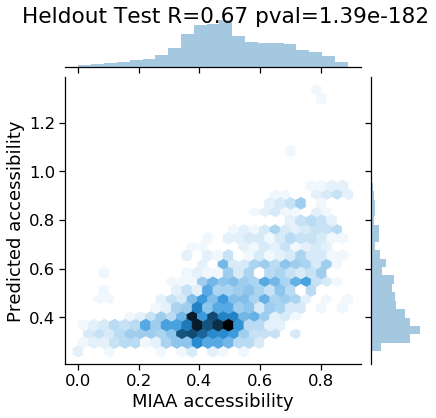

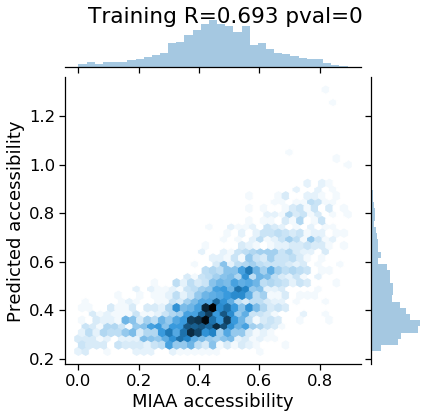

In [18]:
result = OLS(np.log2(train_endog+0.00001),train_exog).fit()
pred = 2**(result.predict(test_exog))
h= sns.jointplot(test_endog,pred,kind='hex')
pcor = pearsonr(test_endog,pred)
pcor = pearsonr(test_endog,pred)
plt.suptitle('Heldout Test R='+str(round(pcor[0],3))+' pval='+str.format('{0:.3g}', pcor[1]))
h.ax_joint.set_xlabel('MIAA accessibility')
h.ax_joint.set_ylabel('Predicted accessibility')
plt.savefig('plots/OSK_FGS_mult_model_test.svg')
pred = 2**(result.predict(train_exog))
h = sns.jointplot(train_endog,pred,kind='hex')
pcor = pearsonr(train_endog,pred)
plt.suptitle('Training R='+str(round(pcor[0],3))+' pval='+str.format('{0:.3g}', pcor[1]))
h.ax_joint.set_xlabel('MIAA accessibility')
h.ax_joint.set_ylabel('Predicted accessibility')
plt.savefig('plots/OSK_FGS_mult_model_train.svg')

In [ ]:
tf_combos = [c for c in all_cats if (len(c.split(','))==2)
            and (('oct4' in c) or ('sox2' in c) or ('klf4' in c))]
tf_combos.extend([c for c in all_cats if (len(c.split(','))==3)
            and (('oct4' in c) or ('sox2' in c) or ('klf4' in c))])
tf_combos.extend([c for c in all_cats if (len(c.split(','))==2)
            and (('foxa2' in c) or ('sox17' in c) or ('gata4' in c))])
tf_combos.extend([c for c in all_cats if (len(c.split(','))==3)
            and (('foxa2' in c) or ('sox17' in c) or ('gata4' in c))])
scores = {}
pvals = {} 
for combo in tf_combos:
    tf_combo_data = keep_melt[(keep_melt['cat']==combo) & (keep_melt['control'] == 'motif')]
    data_mat = np.zeros((len(tf_combo_data),1+len(reps)+len(celltypes)*len(tfs)))
    data_endog = tf_combo_data['value']

    #set X
    start=0
    data_mat[:,start] = tf_combo_data['gc.content']
    start += 1

    for j,rep in enumerate(reps):
        data_mat[:,start+j] = (tf_combo_data['variable']==rep)
        data_mat[:,start+j] = (tf_combo_data['variable']==rep)
    start += len(reps)

    for i,ct in enumerate(celltypes):
        for j,tf in enumerate(tfs):
            def count_tfs(cat):
                data=cat.split(',')
                if tf in data:
                    return data.count(tf)
                else:
                    return 0
            mask = (tf_combo_data['celltype']==ct)&(tf_combo_data['control']=='motif')
            tf_counts = np.array([count_tfs(cat) for cat in tf_combo_data.cat])
            data_mat[:,start+j] = tf_counts*mask    
        start += len(tfs)
        
    data_pred = result.predict(data_mat)
    scores[combo] = mean_squared_error(data_endog,data_pred)
    
    nrandom = 0 
    for i in range(5000):
        random_data = keep_melt[(keep_melt['control'] == 'motif')].sample(n=len(tf_combo_data))
        data_mat = np.zeros((len(tf_combo_data),1+len(reps)+len(celltypes)*len(tfs)))
        data_endog = random_data['value']

        #set X
        start=0
        data_mat[:,start] = random_data['gc.content']
        start += 1

        for j,rep in enumerate(reps):
            data_mat[:,start+j] = (random_data['variable']==rep)
            data_mat[:,start+j] = (random_data['variable']==rep)
        start += len(reps)

        for i,ct in enumerate(celltypes):
            for j,tf in enumerate(tfs):
                def count_tfs(cat):
                    data=cat.split(',')
                    if tf in data:
                        return data.count(tf)
                    else:
                        return 0
                mask = (random_data['celltype']==ct)&(random_data['control']=='motif')
                tf_counts = np.array([count_tfs(cat) for cat in random_data.cat])
                data_mat[:,start+j] = tf_counts*mask    
            start += len(tfs)
        data_pred = result.predict(data_mat)
        if mean_squared_error(data_endog,data_pred) > scores[combo]:
            nrandom +=1
    pvals[combo] = float(nrandom)/5000

In [ ]:
sns.distplot(list(pvals.values()))

In [ ]:
pval_list = [pvals[k] for k in tf_combos]
significantly_under_predicted,_,_,_ = multipletests(pval_list,method='fdr_bh')
nonlinear = [tf_combos[i] for i in range(len(pval_list)) if significantly_under_predicted[i]]
nonlinear_sorted = sorted(nonlinear,key=lambda x: scores[x])

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter([pvals[c] for c in tf_combos],[scores[c] for c in tf_combos],color='k')
plt.scatter([pvals[c] for c in nonlinear],[scores[c] for c in nonlinear],color='r')
plt.ylabel('MSE')
plt.xlabel('p-value')
plt.show()

In [ ]:
for combo in nonlinear_sorted:
    tf_combo_data = keep_melt[(keep_melt['cat']==combo) & (keep_melt['control'] == 'motif')]
    data_mat = np.zeros((len(tf_combo_data),1+len(reps)+len(celltypes)*len(tfs)))
    data_endog = tf_combo_data['value']

    #set X
    start=0
    data_mat[:,start] = tf_combo_data['gc.content']
    start += 1

    for j,rep in enumerate(reps):
        data_mat[:,start+j] = (tf_combo_data['variable']==rep)
    start += len(reps)

    for i,ct in enumerate(celltypes):
        for j,tf in enumerate(tfs):
            def count_tfs(cat):
                data=cat.split(',')
                if tf in data:
                    return data.count(tf)
                else:
                    return 0
            mask = (tf_combo_data['celltype']==ct)&(tf_combo_data['control']=='motif')
            tf_counts = np.array([count_tfs(cat) for cat in tf_combo_data.cat])
            data_mat[:,start+j] = tf_counts*mask    
        start += len(tfs)
        
    data_pred = result.predict(data_mat)
    plt.scatter(data_endog,data_pred)
    plt.xlabel('True MIAA')
    plt.ylabel('Predicted')
    plt.title(combo)
    plt.axis([0,1,0,1])
    plt.show()
    print(pvals[combo],scores[combo])

# Testing non-linear motifs on average accessibility across replicates

In [24]:
tf_singles = list(set([k for k in all_cats if len(k.split(',')) == 1]))
tf_singles

['klf4', 'sox17', 'gata4', 'foxa2', 'sox2', 'oct4']

In [26]:
def gc_model(train,test,y,glm=None):
    X = sm.add_constant(train['gc.content'])
    X_test = sm.add_constant(test['gc.content'])   
    if glm == None:
        glm= sm.OLS(y,X).fit()
    pred = glm.predict(X_test)
    return pred,glm,['offset','GC']

def count_tfs(cat,tf):
    if tf in cat:
        return cat.count(tf)
    else:
        return 0
            
def additive_kmer_model(train,test,y,glm=None):
    tfs = tf_singles
    train_gc = np.array(train['gc.content']).reshape((-1,1))
    train_kmer_mat = np.zeros((train_gc.shape[0],len(tfs)))
    for ki,tf in enumerate(tfs):
        for j,cat in enumerate(list(train.cat)):
            if train.iloc[j]['control'] == 'motif':
                train_kmer_mat[j,ki] = count_tfs(cat,tf)
    X = sm.add_constant(np.concatenate([train_gc,train_kmer_mat],axis=1))
    
    test_gc = np.array(test['gc.content']).reshape((-1,1))
    test_kmer_mat = np.zeros((test_gc.shape[0],len(tfs)))
    for ki,tf in enumerate(tfs):
        for j,cat in enumerate(list(test.cat)):
            if test.iloc[j]['control'] == 'motif':
                test_kmer_mat[j,ki] = count_tfs(cat,tf)
    X_test = sm.add_constant(np.concatenate([test_gc,test_kmer_mat],axis=1))
    if glm == None:
        glm= sm.OLS(y,X).fit()
    pred = glm.predict(X_test)
    return pred,glm,['offset','GC']+list(tfs)

def conditional_kmer_model(train,test,y,glm=None):
    tfs = tf_singles + tf_combos 
    train_gc = np.array(train['gc.content']).reshape((-1,1))
    train_kmer_mat = np.zeros((train_gc.shape[0],len(tfs)))
    for ki,tf in enumerate(tfs):
        #if len(tf.split(',')) == 1:
        for j,cat in enumerate(list(train.cat)):
            if train.iloc[j]['control'] == 'motif':
                train_kmer_mat[j,ki] = count_tfs(cat,tf)
        #else:
        #    train_kmer_mat[:,ki] = (train['cat'] == tf)*(train['control'] == 'motif')
    X = sm.add_constant(np.concatenate([train_gc,train_kmer_mat],axis=1))
    
    test_gc = np.array(test['gc.content']).reshape((-1,1))
    test_kmer_mat = np.zeros((test_gc.shape[0],len(tfs)))
    
    for ki,tf in enumerate(tfs):
        #if len(tf.split(',')) == 1:
        for j,cat in enumerate(list(test.cat)):
            if test.iloc[j]['control'] == 'motif':
                test_kmer_mat[j,ki] = count_tfs(cat,tf)
        #else:
        #    test_kmer_mat[:,ki] = (test['cat'] == tf)*(test['control'] == 'motif')
    X_test = sm.add_constant(np.concatenate([test_gc,test_kmer_mat],axis=1))
    if glm == None:
        glm= sm.OLS(y,X).fit()
    pred = glm.predict(X_test)
    return pred,glm,['offset','GC']+tfs

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

0 train n= 685 test n= 356


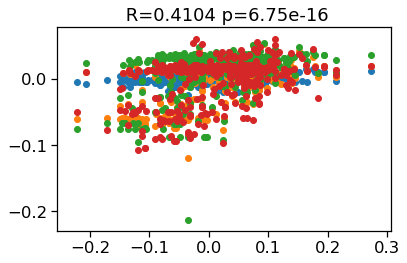

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
1 train n= 695 test n= 346


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


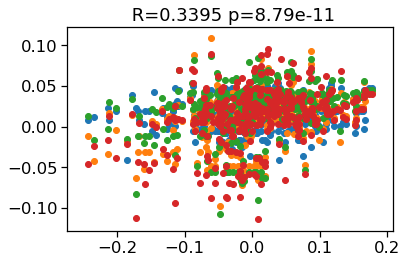

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
2 train n= 686 test n= 355


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


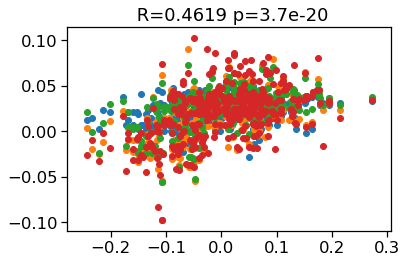

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
3 train n= 694 test n= 347


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


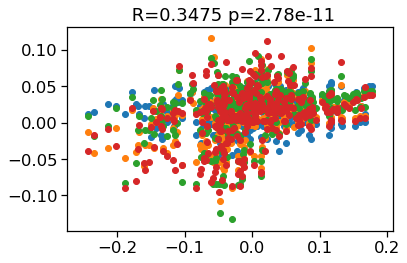

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
4 train n= 695 test n= 346


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


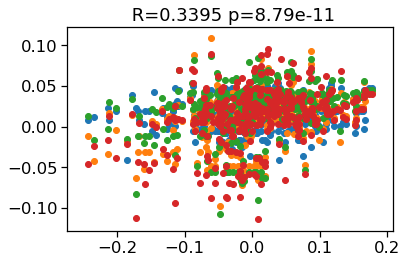

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
5 train n= 690 test n= 351


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


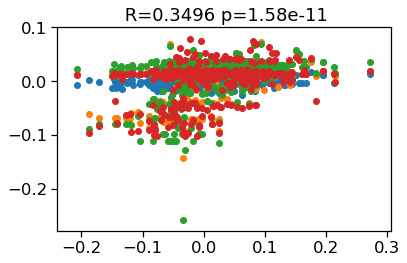

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
6 train n= 690 test n= 351


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


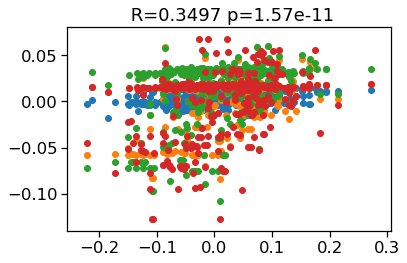

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
7 train n= 702 test n= 339


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


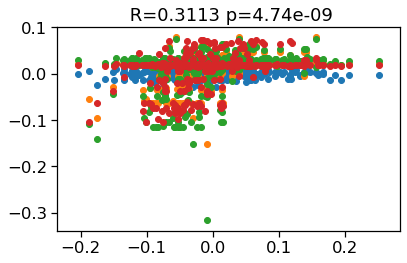

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
8 train n= 696 test n= 345


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


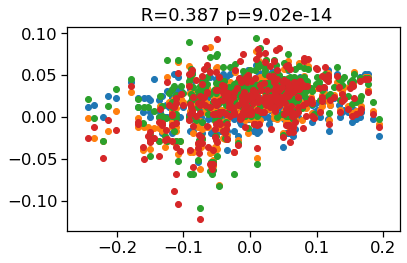

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
9 train n= 694 test n= 347


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


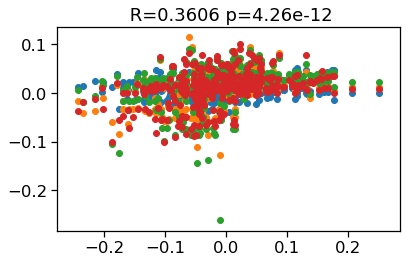

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
10 train n= 700 test n= 341


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


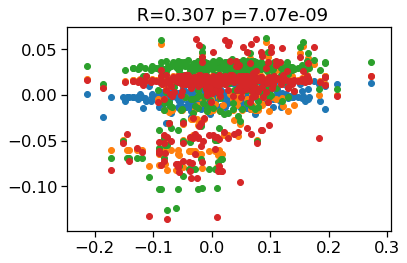

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
11 train n= 690 test n= 351


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


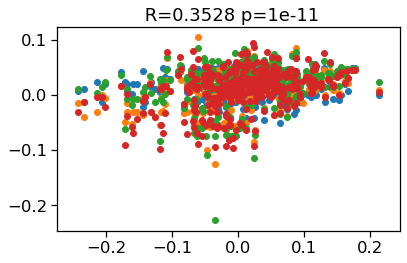

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
12 train n= 694 test n= 347


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


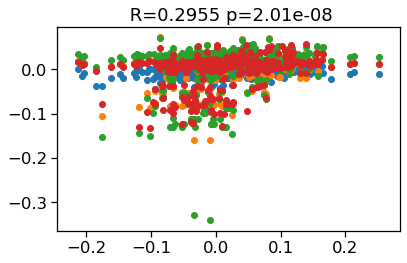

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
13 train n= 697 test n= 344


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


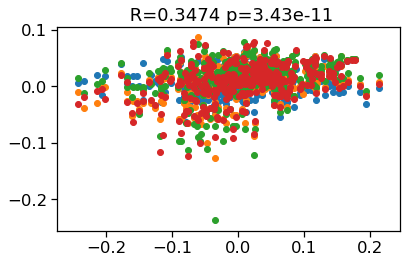

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
14 train n= 692 test n= 349


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


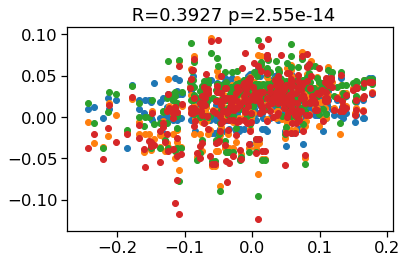

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
15 train n= 692 test n= 349


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


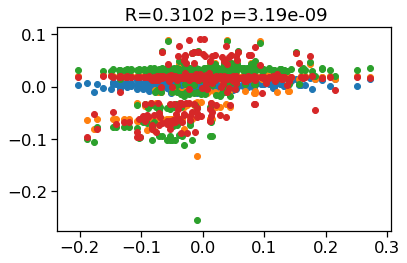

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
16 train n= 693 test n= 348


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


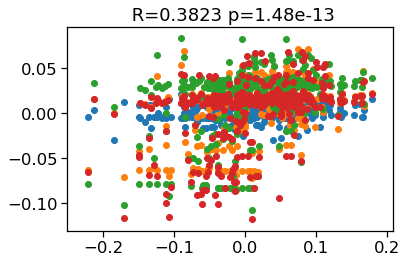

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
17 train n= 695 test n= 346


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


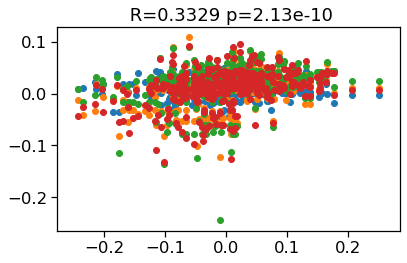

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
18 train n= 703 test n= 338


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


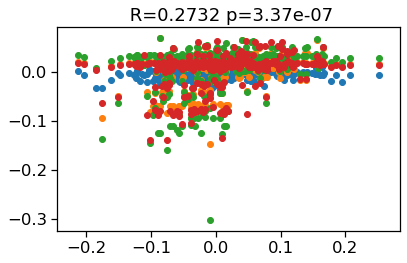

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
19 train n= 689 test n= 352


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


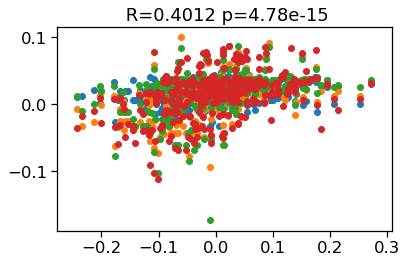

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
20 train n= 692 test n= 349


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


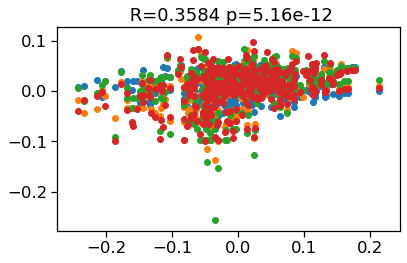

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
21 train n= 696 test n= 345


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


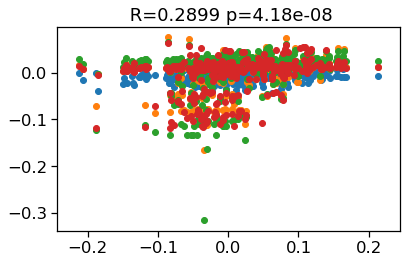

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
22 train n= 694 test n= 347


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


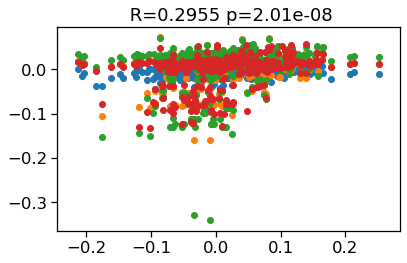

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
23 train n= 696 test n= 345


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


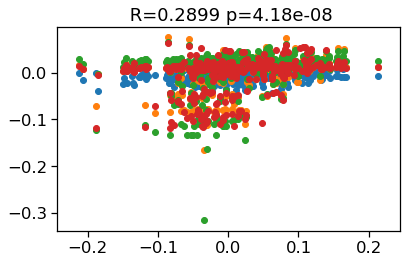

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()
24 train n= 701 test n= 340


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


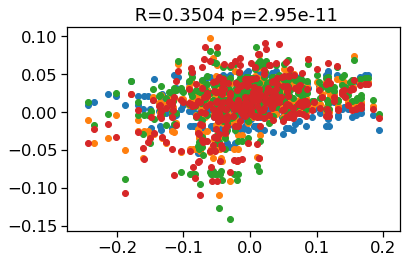

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


set()
set()
set()


In [57]:
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score
import pickle

with open('background_random_sample_pioneer_nonlinear_analysis.pkl','rb') as f:
    #sampled bgs generated from np.random.choice and saved so subsequent analysis
    #remains consistent
    sampled_bgs = pickle.load(f)
    
tf_combos = [c for c in all_cats if (len(c.split(','))==2)
            and (('oct4' in c) or ('sox2' in c) or ('klf4' in c))]
tf_combos.extend([c for c in all_cats if (len(c.split(','))==3)
            and (('oct4' in c) or ('sox2' in c) or ('klf4' in c))])
tf_combos.extend([c for c in all_cats if (len(c.split(','))==2)
            and (('foxa2' in c) or ('sox17' in c) or ('gata4' in c))])
tf_combos.extend([c for c in all_cats if (len(c.split(','))==3)
            and (('foxa2' in c) or ('sox17' in c) or ('gata4' in c))])

keep = data_dpn[data_dpn['cat'].isin([c for c in set(data_dpn['cat']) 
                                      if (('oct4' in c) or ('sox2' in c) or ('klf4' in c)
                                         or ('sox17' in c) or ('gata4' in c) or ('foxa2' in c))])]
keep['gc.content'] = [(s.count('G')+s.count('C'))/float(len(s)) for s in keep.seq]
keep['nmotifs'] = [len(c.split(',')) for c in keep['cat']]
keep['nunique'] = [len(set(c.split(','))) for c in keep['cat']]
keep['ed.average'] = keep['ED Dpn ratio']
keep['es.average'] = keep['ES Dpn ratio']

train_norm = keep
bgs = list(set(train_norm.background))
explained_variance = {'model':[],'eval':[],'es_eval':[],'ed_eval':[],'k':[]}
kmer_ev = {'tfset':[],'model':[],'eval':[],'es_eval':[],'ed_eval':[],'rep':[]}
saved_models = {'ESC':[],'DE':[]}
#sampled_bgs=[]
for k in range(25):
    #bgkeep = np.random.choice(bgs,6,replace=False)
    #sampled_bgs.append(bgkeep)
    bgkeep = sampled_bgs[k]
    train_set = train_norm[train_norm['background'].isin(bgkeep)]
    test_set = train_norm[~train_norm['background'].isin(bgkeep)]
    print(k,'train n=',len(train_set),'test n=',len(test_set))
    gc_pred_ed,gc_glm,_ = gc_model(train_set,test_set,train_set['ed.average'])
    additive_pred_ed,additive_glm,additive_vars = additive_kmer_model(train_set,test_set,
                                                                   train_set['ed.average'])
    
    multiplicative_pred_ed,multiplicative_glm,multiplicative_vars = additive_kmer_model(train_set,test_set,
                                                                   np.log10(train_set['ed.average']))
    conditional_pred_ed,conditional_glm,conditional_vars = conditional_kmer_model(train_set,test_set,
                                                                   train_set['ed.average'])
    saved_models['DE'].append({'additive':additive_glm,
                                'GC':gc_glm,
                                'conditional':conditional_glm,
                                'multiplicative':multiplicative_glm})
    
    gc_pred_es,gc_glm,_ = gc_model(train_set,test_set,train_set['es.average'])
    additive_pred_es,additive_glm,additive_vars = additive_kmer_model(train_set,test_set,
                                                                   train_set['es.average'])
    multiplicative_pred_es,multiplicative_glm,multiplicative_vars = additive_kmer_model(train_set,test_set,
                                                                   np.log10(train_set['es.average']))
    conditional_pred_es,conditional_glm,conditional_vars = conditional_kmer_model(train_set,test_set,
                                                                   train_set['es.average'])
    saved_models['ESC'].append({'additive':additive_glm,
                                'GC':gc_glm,
                                'conditional':conditional_glm,
                                'multiplicative':multiplicative_glm})
    explained_variance['model'].extend(['GC','additive','multiplicative','conditional'])
    explained_variance['eval'].extend([explained_variance_score((test_set['ed.average']-test_set['es.average']),
                                        (gc_pred_ed-gc_pred_es)),
                              explained_variance_score((test_set['ed.average']-test_set['es.average']),
                                        (additive_pred_ed-additive_pred_es)),
                              explained_variance_score((test_set['ed.average']-test_set['es.average']),
                                        10**multiplicative_pred_ed - 10**multiplicative_pred_es),
                              explained_variance_score((test_set['ed.average']-test_set['es.average']),
                                        (conditional_pred_ed-conditional_pred_es))])
    explained_variance['es_eval'].extend([explained_variance_score((test_set['es.average']),
                                        (gc_pred_es)),
                              explained_variance_score((test_set['es.average']),
                                        (additive_pred_es)),
                              explained_variance_score((test_set['es.average']),
                                        10**multiplicative_pred_es),
                              explained_variance_score((test_set['es.average']),
                                        (conditional_pred_es))])
    explained_variance['ed_eval'].extend([explained_variance_score(np.log10(test_set['ed.average']),
                                        (gc_pred_ed)),
                              explained_variance_score(np.log10(test_set['ed.average']),
                                        (additive_pred_ed)),
                              explained_variance_score((test_set['ed.average']),
                                        10**multiplicative_pred_ed),
                              explained_variance_score((test_set['ed.average']),
                                        (conditional_pred_ed))])
    
    plot_scatter((test_set['ed.average']-test_set['es.average']),
                                        (gc_pred_ed-gc_pred_es))
    #plt.show()
    plot_scatter((test_set['ed.average']-test_set['es.average']),
                 (additive_pred_ed-additive_pred_es))
    #plt.show()
    plot_scatter((test_set['ed.average']-test_set['es.average']),
                10**multiplicative_pred_ed - 10**multiplicative_pred_es)
    #plt.show()
    plot_scatter((test_set['ed.average']-test_set['es.average']),
                (conditional_pred_ed-conditional_pred_es))
    plt.show()
    print(set(test_set[np.log10(test_set['ed.average']-test_set['es.average'])>0.5]['tf']))
    print(set(test_set[np.log10(test_set['ed.average']-test_set['es.average'])>0.5]['background']))
    print(set(test_set[np.log10(test_set['ed.average']-test_set['es.average'])>0.5]['control']))
    explained_variance['k'].extend([k for _ in range(4)])
    for tfset in all_cats:
        test_set_kmer = test_set[(test_set['cat'] == tfset) & (test_set['control'] == 'motif')]
        kmer_mask = (test_set['cat'] == tfset) & (test_set['control'] == 'motif')
        if np.sum(kmer_mask) == 0:
            continue
        kmer_ev['tfset'].extend([tfset,tfset,tfset,tfset])
        kmer_ev['model'].extend(['GC','additive','multiplicative','conditional'])
        kmer_ev['eval'].extend([mean_squared_error((test_set_kmer['ed.average']-test_set_kmer['es.average']),
                                        (gc_pred_ed[kmer_mask]-gc_pred_es[kmer_mask])),
                              mean_squared_error((test_set_kmer['ed.average']-test_set_kmer['es.average']),
                                        (additive_pred_ed[kmer_mask]-additive_pred_es[kmer_mask])),
                              mean_squared_error((test_set_kmer['ed.average']-test_set_kmer['es.average']),
                                        10**multiplicative_pred_ed[kmer_mask] - 10**multiplicative_pred_es[kmer_mask]),
                              mean_squared_error((test_set_kmer['ed.average']-test_set_kmer['es.average']),
                                        (conditional_pred_ed[kmer_mask]-conditional_pred_es[kmer_mask]))])
        kmer_ev['es_eval'].extend([mean_squared_error(test_set_kmer['es.average'],
                                        gc_pred_es[kmer_mask]),
                              mean_squared_error(test_set_kmer['es.average'],
                                        additive_pred_es[kmer_mask]),
                              mean_squared_error(np.log10(test_set_kmer['es.average']),
                                                 multiplicative_pred_es[kmer_mask]),
                              mean_squared_error(test_set_kmer['es.average'],
                                        conditional_pred_es[kmer_mask])])
        kmer_ev['ed_eval'].extend([mean_squared_error(test_set_kmer['ed.average'],
                                        gc_pred_ed[kmer_mask]),
                              mean_squared_error(test_set_kmer['ed.average'],
                                        additive_pred_ed[kmer_mask]),
                              mean_squared_error(np.log10(test_set_kmer['ed.average']),
                                                 multiplicative_pred_ed[kmer_mask]),
                              mean_squared_error(test_set_kmer['ed.average'],
                                        conditional_pred_ed[kmer_mask])])
        
        kmer_ev['rep'].extend([k,k,k,k])

0.8994196783399859 0.9999548890863583 6.128468010809964e-06
0.6811563834596805 6.128468010809964e-06 6.128468010809964e-06
0.9956520044046652 0.9999938715319892 2.560443548752839e-05


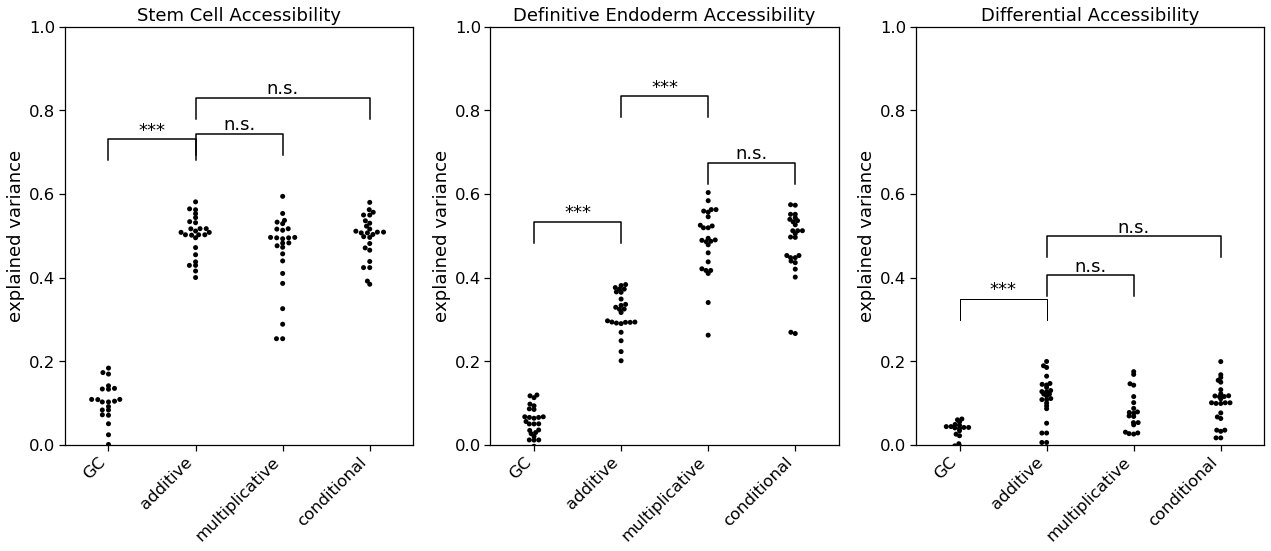

In [72]:
evaldf = pd.DataFrame(explained_variance)

sns.set_context('notebook',font_scale=1.5)
plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
g = sns.swarmplot(x='model',y='es_eval',data=evaldf,color='black')
plt.setp(g.get_xticklabels(), ha="right", rotation=45)
plt.ylabel('explained variance')
eval_pivot = evaldf.pivot_table(index=['k'],columns=['model'],values=['es_eval'])
test1 = wilcoxon(eval_pivot['es_eval'].conditional,eval_pivot['es_eval'].additive,alternative='greater')[1]
test2 = wilcoxon(eval_pivot['es_eval'].multiplicative,eval_pivot['es_eval'].additive,alternative='greater')[1]
test3 = wilcoxon(eval_pivot['es_eval'].additive,eval_pivot['es_eval'].GC,alternative='greater')[1]

plt.xlabel('')
def ptostar(pval):
    p1 = 'n.s.'
    if pval < 0.05:
        p1 = '*'
    if pval < 0.01:
        p1 = '**'
    if pval < 0.001:
        p1 = '***'
    return p1
p1 = ptostar(test1)
p2 = ptostar(test2)
p3 = ptostar(test3)
print(test1,test2,test3)
dist1=0.05
dist2=0.2
x1,x2 = 1,3
y, h, col = eval_pivot['es_eval'].conditional.max() + 0.2, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p1, ha='center', va='bottom', color=col)
x1,x2 = 1,2
y, h, col = eval_pivot['es_eval'].multiplicative.max() + 0.10, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p2, ha='center', va='bottom', color=col)
x1,x2 = 0,1
y, h, col = eval_pivot['es_eval'].additive.max() + 0.1, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p3, ha='center', va='bottom', color=col)
plt.xlabel('')
plt.axis([-0.5,3.5,0,1.0])

plt.title('Stem Cell Accessibility')
plt.tight_layout()

plt.subplot(1,3,2)
g = sns.swarmplot(x='model',y='ed_eval',data=evaldf,color='black')
plt.setp(g.get_xticklabels(), ha="right", rotation=45)
plt.ylabel('explained variance')
plt.xlabel('')
eval_pivot = evaldf.pivot_table(index=['k'],columns=['model'],values=['ed_eval'])
test1 = wilcoxon(eval_pivot['ed_eval'].conditional,eval_pivot['ed_eval'].multiplicative,alternative='greater')[1]
test2 = wilcoxon(eval_pivot['ed_eval'].multiplicative,eval_pivot['ed_eval'].additive,alternative='greater')[1]
test3 = wilcoxon(eval_pivot['ed_eval'].additive,eval_pivot['ed_eval'].GC,alternative='greater')[1]

plt.xlabel('')
def ptostar(pval):
    p1 = 'n.s.'
    if pval < 0.05:
        p1 = '*'
    if pval < 0.01:
        p1 = '**'
    if pval < 0.001:
        p1 = '***'
    return p1
p1 = ptostar(test1)
p2 = ptostar(test2)
p3 = ptostar(test3)
print(test1,test2,test3)
dist1=0.05
dist2=0.2
x1,x2 = 2,3
y, h, col = eval_pivot['ed_eval'].conditional.max() + 0.05, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p1, ha='center', va='bottom', color=col)
x1,x2 = 1,2
y, h, col = eval_pivot['ed_eval'].multiplicative.max() + 0.18, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p2, ha='center', va='bottom', color=col)
x1,x2 = 0,1
y, h, col = eval_pivot['ed_eval'].additive.max() + 0.1, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p3, ha='center', va='bottom', color=col)
plt.xlabel('')
plt.axis([-0.5,3.5,0,1.0])


plt.title('Definitive Endoderm Accessibility')
plt.subplot(1,3,3)
g = sns.swarmplot(x='model',y='eval',data=evaldf,color='black')
plt.tight_layout()

plt.setp(g.get_xticklabels(), ha="right", rotation=45)
plt.ylabel('explained variance')
plt.xlabel('')

eval_pivot = evaldf.pivot_table(index=['k'],columns=['model'],values=['eval'])
test1 = wilcoxon(eval_pivot['eval'].conditional,eval_pivot['eval'].additive,alternative='greater')[1]
test2 = wilcoxon(eval_pivot['eval'].multiplicative,eval_pivot['eval'].additive,alternative='greater')[1]
test3 = wilcoxon(eval_pivot['eval'].additive,eval_pivot['eval'].GC,alternative='greater')[1]

plt.xlabel('')
def ptostar(pval):
    p1 = 'n.s.'
    if pval < 0.05:
        p1 = '*'
    if pval < 0.01:
        p1 = '**'
    if pval < 0.001:
        p1 = '***'
    return p1
p1 = ptostar(test1)
p2 = ptostar(test2)
p3 = ptostar(test3)
print(test1,test2,test3)
dist1=0.05
dist2=0.2
x1,x2 = 1,3
y, h, col = eval_pivot['eval'].conditional.max() + dist2+0.05, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p1, ha='center', va='bottom', color=col)
x1,x2 = 1,2
y, h, col = eval_pivot['eval'].multiplicative.max() + 0.18, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p2, ha='center', va='bottom', color=col)
x1,x2 = 0,1
y, h, col = eval_pivot['eval'].additive.max() + 0.1, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*0.5, y+h, p3, ha='center', va='bottom', color=col)
plt.xlabel('')
plt.axis([-0.5,3.5,0,1.0])

plt.title('Differential Accessibility')
plt.tight_layout()
#plt.savefig('plots/OSKFGS-compare_regression_models_accessibility.svg')
plt.show()

In [43]:
'''
import pickle
with open('background_random_sample_pioneer_nonlinear_analysis.pkl','wb') as f:
    pickle.dump(sampled_bgs,f)
'''

In [65]:
kmer_conditional_data = pd.DataFrame(kmer_ev)
plt.figure(figsize=(5,5))
is_significant = {}
best_model_de = {}
for tfset in tf_combos:
    tmp = kmer_conditional_data[kmer_conditional_data['tfset']==tfset]
    tmppv = tmp.pivot_table(index='rep',columns='model',values='ed_eval')
    best_model = 'additive'
    for model in ['multiplicative','conditional']:
        test = wilcoxon(tmppv[model],tmppv[best_model],alternative='less')
        if test[1] < 0.01:
            best_model = model
    best_model_de[tfset] = best_model


<Figure size 360x360 with 0 Axes>

In [66]:
kmer_conditional_data = pd.DataFrame(kmer_ev)
plt.figure(figsize=(5,5))
is_significant = {}
best_model_esc = {}
for tfset in tf_combos:
    tmp = kmer_conditional_data[kmer_conditional_data['tfset']==tfset]
    tmppv = tmp.pivot_table(index='rep',columns='model',values='es_eval')
    best_model = 'additive'
    for model in ['multiplicative','conditional']:
        test = wilcoxon(tmppv[model],tmppv[best_model],alternative='less')
        if test[1] < 0.01:
            best_model = model
    best_model_esc[tfset] = best_model


<Figure size 360x360 with 0 Axes>

In [67]:
kmer_conditional_data = pd.DataFrame(kmer_ev)
plt.figure(figsize=(5,5))
is_significant = {}
best_model_diff= {}
for tfset in tf_combos:
    tmp = kmer_conditional_data[kmer_conditional_data['tfset']==tfset]
    tmppv = tmp.pivot_table(index='rep',columns='model',values='eval')
    best_model='additive'
    for model in ['multiplicative','conditional']:
        test = wilcoxon(tmppv[model],tmppv[best_model],alternative='less')
        if test[1] < 0.05:
            best_model = model
    best_model_diff[tfset] = best_model


<Figure size 360x360 with 0 Axes>

In [68]:
best_model_eval = pd.DataFrame({'TF-combo':tf_combos,
                               'Best Model ESC':[best_model_esc[tf] for tf in tf_combos],
                               'Best Model DE':[best_model_de[tf] for tf in tf_combos],
                               'Best Model Differential':[best_model_diff[tf] for tf in tf_combos],
                               'Is Differential':[tf in scram_diff_sig_ordered for tf in tf_combos]})
#best_model_eval.to_csv('nonlinear-OSKFG-results.csv')

In [69]:
best_model_eval

TF-combo  Best Model ESC   Best Model DE Best Model Differential  \
0           oct4,sox2  multiplicative  multiplicative                additive   
1           oct4,klf4  multiplicative  multiplicative                additive   
2           sox2,sox2  multiplicative  multiplicative                additive   
3           oct4,oct4  multiplicative  multiplicative                additive   
4           klf4,sox2  multiplicative  multiplicative                additive   
5           klf4,oct4     conditional  multiplicative                additive   
6           sox2,klf4        additive  multiplicative                additive   
7           klf4,klf4        additive  multiplicative                additive   
8           sox2,oct4  multiplicative  multiplicative                additive   
9      sox2,oct4,klf4  multiplicative  multiplicative                additive   
10     oct4,oct4,oct4  multiplicative  multiplicative                additive   
11     oct4,klf4,sox2  multiplicative  multiplicative             conditional   
12     oct4,sox2,klf4  multiplicative  multiplicative             conditional   
13     klf4,sox2,oct4  multiplicative  multiplicative                additive   
14     klf4,klf4,klf4        additive        additive             conditional   
15     sox2,klf4,oct4  multiplicative  multiplicative                additive   
16     klf4,oct4,sox2  multiplicative  multiplicative                additive   
17     sox2,sox2,sox2  multiplicative  multiplicative                additive   
18        sox17,gata4  multiplicative  multiplicative          multiplicative   
19        foxa2,foxa2        additive        additive                additive   
20        sox17,foxa2        additive  multiplicative                additive   
21        sox17,sox17  multiplicative  multiplicative                additive   
22        gata4,foxa2        additive        additive                additive   
23        foxa2,sox17        additive  multiplicative                additive   
24        foxa2,gata4        additive        additive          multiplicative   
25        gata4,gata4        additive        additive          multiplicative   
26        gata4,sox17  multiplicative  multiplicative                additive   
27  foxa2,gata4,sox17        additive  multiplicative                additive   
28  foxa2,sox17,gata4  multiplicative  multiplicative                additive   
29  gata4,sox17,foxa2  multiplicative  multiplicative          multiplicative   
30  sox17,sox17,sox17  multiplicative  multiplicative                additive   
31  gata4,gata4,gata4     conditional        additive             conditional   
32  sox17,foxa2,gata4  multiplicative  multiplicative                additive   
33  gata4,foxa2,sox17        additive  multiplicative                additive   
34  foxa2,foxa2,foxa2        additive     conditional                additive   
35  sox17,gata4,foxa2  multiplicative  multiplicative                additive   

    Is Differential  
0             False  
1              True  
2              True  
3             False  
4              True  
5             False  
6              True  
7              True  
8             False  
9             False  
10            False  
11             True  
12             True  
13             True  
14            False  
15             True  
16            False  
17             True  
18             True  
19            False  
20            False  
21             True  
22             True  
23            False  
24             True  
25            False  
26            False  
27            False  
28            False  
29            False  
30             True  
31            False  
32            False  
33            False  
34            False  
35            False

In [73]:
tf_nonlinear = [tf for tf in tf_combos if best_model_diff[tf] != 'additive']

In [74]:
def final_conditional_kmer_model(train,test,y,glm=None):
    tfs = tf_singles + tf_nonlinear
    train_gc = np.array(train['gc.content']).reshape((-1,1))
    train_kmer_mat = np.zeros((train_gc.shape[0],len(tfs)))
    for ki,tf in enumerate(tfs):
        #if len(tf.split(',')) == 1:
        for j,cat in enumerate(list(train.cat)):
            if train.iloc[j]['control'] == 'motif':
                train_kmer_mat[j,ki] = count_tfs(cat,tf)
        #else:
        #    train_kmer_mat[:,ki] = (train['cat'] == tf)*(train['control'] == 'motif')
    X = sm.add_constant(np.concatenate([train_gc,train_kmer_mat],axis=1))
    
    test_gc = np.array(test['gc.content']).reshape((-1,1))
    test_kmer_mat = np.zeros((test_gc.shape[0],len(tfs)))
    
    for ki,tf in enumerate(tfs):
        #if len(tf.split(',')) == 1:
        for j,cat in enumerate(list(test.cat)):
            if test.iloc[j]['control'] == 'motif':
                test_kmer_mat[j,ki] = count_tfs(cat,tf)
        #else:
        #    test_kmer_mat[:,ki] = (test['cat'] == tf)*(test['control'] == 'motif')
    X_test = sm.add_constant(np.concatenate([test_gc,test_kmer_mat],axis=1))
    if glm == None:
        glm= sm.OLS(y,X).fit()
    pred = glm.predict(X_test)
    return pred,glm,['offset','GC']+tfs

In [75]:
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score
import pickle

with open('background_random_sample_pioneer_nonlinear_analysis.pkl','rb') as f:
    #sampled bgs generated from np.random.choice and saved so subsequent analysis
    #remains consistent
    sampled_bgs = pickle.load(f)
    
tf_combos = [c for c in all_cats if (len(c.split(','))==2)
            and (('oct4' in c) or ('sox2' in c) or ('klf4' in c))]
tf_combos.extend([c for c in all_cats if (len(c.split(','))==3)
            and (('oct4' in c) or ('sox2' in c) or ('klf4' in c))])
tf_combos.extend([c for c in all_cats if (len(c.split(','))==2)
            and (('foxa2' in c) or ('sox17' in c) or ('gata4' in c))])
tf_combos.extend([c for c in all_cats if (len(c.split(','))==3)
            and (('foxa2' in c) or ('sox17' in c) or ('gata4' in c))])

keep = data_dpn[data_dpn['cat'].isin([c for c in set(data_dpn['cat']) 
                                      if (('oct4' in c) or ('sox2' in c) or ('klf4' in c)
                                         or ('sox17' in c) or ('gata4' in c) or ('foxa2' in c))])]
keep['gc.content'] = [(s.count('G')+s.count('C'))/float(len(s)) for s in keep.seq]
keep['nmotifs'] = [len(c.split(',')) for c in keep['cat']]
keep['nunique'] = [len(set(c.split(','))) for c in keep['cat']]
keep['ed.average'] = keep['ED Dpn ratio']
keep['es.average'] = keep['ES Dpn ratio']

train_norm = keep
bgs = list(set(train_norm.background))
explained_variance = {'model':[],'eval':[],'es_eval':[],'ed_eval':[],'k':[]}
kmer_ev = {'tfset':[],'model':[],'eval':[],'es_eval':[],'ed_eval':[],'rep':[]}
saved_models = {'ESC':[],'DE':[]}
#sampled_bgs=[]
for k in range(25):
    #bgkeep = np.random.choice(bgs,6,replace=False)
    #sampled_bgs.append(bgkeep)
    bgkeep = sampled_bgs[k]
    train_set = train_norm[train_norm['background'].isin(bgkeep)]
    test_set = train_norm[~train_norm['background'].isin(bgkeep)]
    print(k,'train n=',len(train_set),'test n=',len(test_set))
    gc_pred_ed,gc_glm,_ = gc_model(train_set,test_set,train_set['ed.average'])
    additive_pred_ed,additive_glm,additive_vars = additive_kmer_model(train_set,test_set,
                                                                   train_set['ed.average'])
    
    multiplicative_pred_ed,multiplicative_glm,multiplicative_vars = additive_kmer_model(train_set,test_set,
                                                                   np.log10(train_set['ed.average']))
    conditional_pred_ed,conditional_glm,conditional_vars = final_conditional_kmer_model(train_set,test_set,
                                                                   train_set['ed.average'])
    saved_models['DE'].append({'additive':additive_glm,
                                'GC':gc_glm,
                                'conditional':conditional_glm,
                                'multiplicative':multiplicative_glm})
    
    gc_pred_es,gc_glm,_ = gc_model(train_set,test_set,train_set['es.average'])
    additive_pred_es,additive_glm,additive_vars = additive_kmer_model(train_set,test_set,
                                                                   train_set['es.average'])
    multiplicative_pred_es,multiplicative_glm,multiplicative_vars = additive_kmer_model(train_set,test_set,
                                                                   np.log10(train_set['es.average']))
    conditional_pred_es,conditional_glm,conditional_vars = final_conditional_kmer_model(train_set,test_set,
                                                                   train_set['es.average'])
    saved_models['ESC'].append({'additive':additive_glm,
                                'GC':gc_glm,
                                'conditional':conditional_glm,
                                'multiplicative':multiplicative_glm})
    explained_variance['model'].extend(['GC','additive','multiplicative','conditional'])
    explained_variance['eval'].extend([explained_variance_score((test_set['ed.average']-test_set['es.average']),
                                        (gc_pred_ed-gc_pred_es)),
                              explained_variance_score((test_set['ed.average']-test_set['es.average']),
                                        (additive_pred_ed-additive_pred_es)),
                              explained_variance_score((test_set['ed.average']-test_set['es.average']),
                                        10**multiplicative_pred_ed - 10**multiplicative_pred_es),
                              explained_variance_score((test_set['ed.average']-test_set['es.average']),
                                        (conditional_pred_ed-conditional_pred_es))])
    explained_variance['es_eval'].extend([explained_variance_score((test_set['es.average']),
                                        (gc_pred_es)),
                              explained_variance_score((test_set['es.average']),
                                        (additive_pred_es)),
                              explained_variance_score((test_set['es.average']),
                                        10**multiplicative_pred_es),
                              explained_variance_score((test_set['es.average']),
                                        (conditional_pred_es))])
    explained_variance['ed_eval'].extend([explained_variance_score((test_set['ed.average']),
                                        (gc_pred_ed)),
                              explained_variance_score((test_set['ed.average']),
                                        (additive_pred_ed)),
                              explained_variance_score((test_set['ed.average']),
                                        10**multiplicative_pred_ed),
                              explained_variance_score((test_set['ed.average']),
                                        (conditional_pred_ed))])
    
    explained_variance['k'].extend([k for _ in range(4)])

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

0 train n= 685 test n= 356
1 train n= 695 test n= 346


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


2 train n= 686 test n= 355


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


3 train n= 694 test n= 347


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


4 train n= 695 test n= 346


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


5 train n= 690 test n= 351


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


6 train n= 690 test n= 351


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


7 train n= 702 test n= 339


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


8 train n= 696 test n= 345


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


9 train n= 694 test n= 347


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


10 train n= 700 test n= 341


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


11 train n= 690 test n= 351


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


12 train n= 694 test n= 347


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


13 train n= 697 test n= 344


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


14 train n= 692 test n= 349


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


15 train n= 692 test n= 349


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


16 train n= 693 test n= 348


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


17 train n= 695 test n= 346


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


18 train n= 703 test n= 338


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


19 train n= 689 test n= 352


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


20 train n= 692 test n= 349


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


21 train n= 696 test n= 345


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


22 train n= 694 test n= 347


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


23 train n= 696 test n= 345


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


24 train n= 701 test n= 340


/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


0.009269470004507183 0.9999548890863583 6.128468010809964e-06
0.537519685418231 0.5588318151271443 6.128468010809964e-06
6.128468010809964e-06 0.9999938715319892 2.560443548752839e-05


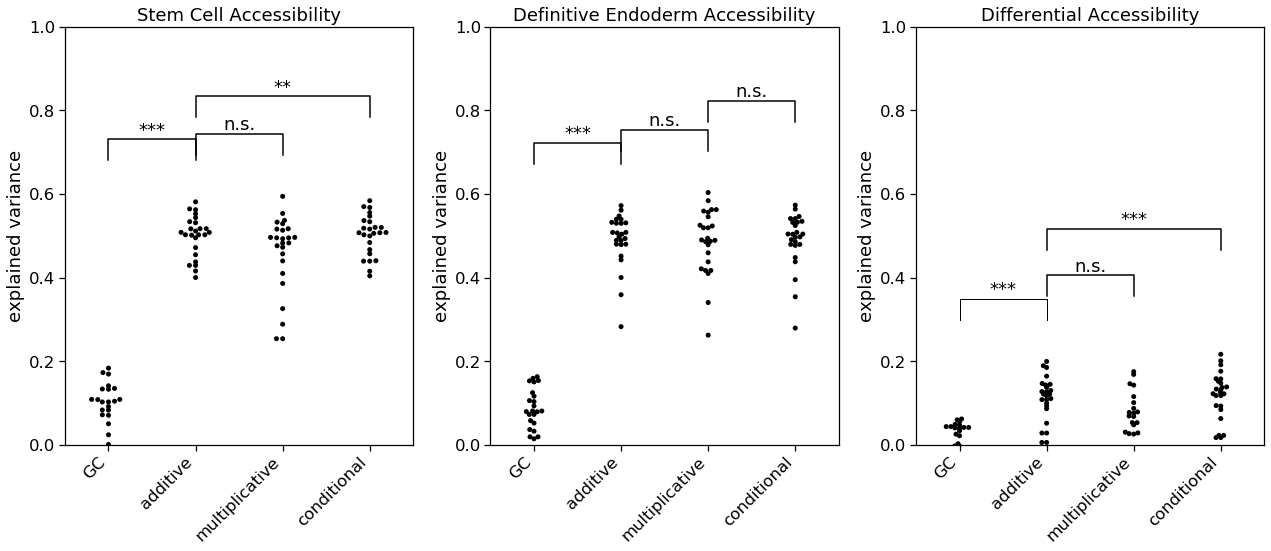

In [79]:
evaldf = pd.DataFrame(explained_variance)

sns.set_context('notebook',font_scale=1.5)
plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
g = sns.swarmplot(x='model',y='es_eval',data=evaldf,color='black')
plt.setp(g.get_xticklabels(), ha="right", rotation=45)
plt.ylabel('explained variance')
eval_pivot = evaldf.pivot_table(index=['k'],columns=['model'],values=['es_eval'])
test1 = wilcoxon(eval_pivot['es_eval'].conditional,eval_pivot['es_eval'].additive,alternative='greater')[1]
test2 = wilcoxon(eval_pivot['es_eval'].multiplicative,eval_pivot['es_eval'].additive,alternative='greater')[1]
test3 = wilcoxon(eval_pivot['es_eval'].additive,eval_pivot['es_eval'].GC,alternative='greater')[1]

plt.xlabel('')
def ptostar(pval):
    p1 = 'n.s.'
    if pval < 0.05:
        p1 = '*'
    if pval < 0.01:
        p1 = '**'
    if pval < 0.001:
        p1 = '***'
    return p1
p1 = ptostar(test1)
p2 = ptostar(test2)
p3 = ptostar(test3)
print(test1,test2,test3)
dist1=0.05
dist2=0.2
x1,x2 = 1,3
y, h, col = eval_pivot['es_eval'].conditional.max() + 0.20, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p1, ha='center', va='bottom', color=col)
x1,x2 = 1,2
y, h, col = eval_pivot['es_eval'].multiplicative.max() + 0.1, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p2, ha='center', va='bottom', color=col)
x1,x2 = 0,1
y, h, col = eval_pivot['es_eval'].additive.max() + 0.1, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p3, ha='center', va='bottom', color=col)
plt.xlabel('')
plt.axis([-0.5,3.5,0,1.0])

plt.title('Stem Cell Accessibility')
plt.tight_layout()

plt.subplot(1,3,2)
g = sns.swarmplot(x='model',y='ed_eval',data=evaldf,color='black')
plt.setp(g.get_xticklabels(), ha="right", rotation=45)
plt.ylabel('explained variance')
plt.xlabel('')
eval_pivot = evaldf.pivot_table(index=['k'],columns=['model'],values=['ed_eval'])
test1 = wilcoxon(eval_pivot['ed_eval'].conditional,eval_pivot['ed_eval'].multiplicative,alternative='greater')[1]
test2 = wilcoxon(eval_pivot['ed_eval'].multiplicative,eval_pivot['ed_eval'].additive,alternative='greater')[1]
test3 = wilcoxon(eval_pivot['ed_eval'].additive,eval_pivot['ed_eval'].GC,alternative='greater')[1]

plt.xlabel('')
def ptostar(pval):
    p1 = 'n.s.'
    if pval < 0.05:
        p1 = '*'
    if pval < 0.01:
        p1 = '**'
    if pval < 0.001:
        p1 = '***'
    return p1
p1 = ptostar(test1)
p2 = ptostar(test2)
p3 = ptostar(test3)
print(test1,test2,test3)
dist1=0.05
dist2=0.2
x1,x2 = 2,3
y, h, col = eval_pivot['ed_eval'].conditional.max() + 0.20, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p1, ha='center', va='bottom', color=col)
x1,x2 = 1,2
y, h, col = eval_pivot['ed_eval'].multiplicative.max() + 0.1, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p2, ha='center', va='bottom', color=col)
x1,x2 = 0,1
y, h, col = eval_pivot['ed_eval'].additive.max() + 0.1, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p3, ha='center', va='bottom', color=col)
plt.xlabel('')
plt.axis([-0.5,3.5,0,1.0])


plt.title('Definitive Endoderm Accessibility')
plt.subplot(1,3,3)
g = sns.swarmplot(x='model',y='eval',data=evaldf,color='black')
plt.tight_layout()

plt.setp(g.get_xticklabels(), ha="right", rotation=45)
plt.ylabel('explained variance')
plt.xlabel('')

eval_pivot = evaldf.pivot_table(index=['k'],columns=['model'],values=['eval'])
test1 = wilcoxon(eval_pivot['eval'].conditional,eval_pivot['eval'].multiplicative,alternative='greater')[1]
test2 = wilcoxon(eval_pivot['eval'].multiplicative,eval_pivot['eval'].additive,alternative='greater')[1]
test3 = wilcoxon(eval_pivot['eval'].additive,eval_pivot['eval'].GC,alternative='greater')[1]

plt.xlabel('')
def ptostar(pval):
    p1 = 'n.s.'
    if pval < 0.05:
        p1 = '*'
    if pval < 0.01:
        p1 = '**'
    if pval < 0.001:
        p1 = '***'
    return p1
p1 = ptostar(test1)
p2 = ptostar(test2)
p3 = ptostar(test3)
print(test1,test2,test3)
dist1=0.05
dist2=0.2
x1,x2 = 1,3
y, h, col = eval_pivot['eval'].conditional.max() + dist2+0.05, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p1, ha='center', va='bottom', color=col)
x1,x2 = 1,2
y, h, col = eval_pivot['eval'].multiplicative.max() + 0.18, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*0.5, y+h, p2, ha='center', va='bottom', color=col)
x1,x2 = 0,1
y, h, col = eval_pivot['eval'].additive.max() + 0.1, dist1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*0.5, y+h, p3, ha='center', va='bottom', color=col)
plt.xlabel('')
plt.axis([-0.5,3.5,0,1.0])

plt.title('Differential Accessibility')
plt.tight_layout()
#plt.savefig('plots/OSKFGS-compare_regression_models_accessibility.svg')
plt.show()

# Linear regression of all parameters, regularization

In [ ]:
reps = list(set(keep_melt['variable']))
celltypes = ['mesc','endoderm']#list(set(keep_melt['celltype']))
tf_combos = [c for c in all_cats if (len(c.split(','))==2)
            and (('oct4' in c) or ('sox2' in c) or ('klf4' in c))]
tf_combos.extend([c for c in all_cats if (len(c.split(','))==3)
            and (('oct4' in c) or ('sox2' in c) or ('klf4' in c))])
tf_combos.extend([c for c in all_cats if (len(c.split(','))==2)
            and (('foxa2' in c) or ('sox17' in c) or ('gata4' in c))])
tf_combos.extend([c for c in all_cats if (len(c.split(','))==3)
            and (('foxa2' in c) or ('sox17' in c) or ('gata4' in c))])
train_exog_m2 = np.zeros((len(train_data),len(celltypes)*len(tf_combos)+4))
test_exog_m2 = np.zeros((len(test_data),len(celltypes)*len(tf_combos)+4))
start=0
for i,ct in enumerate(celltypes):
    for j,tf in enumerate(tf_combos):
        train_exog_m2[:,start+j] = (train_data['cat']==tf)*(train_data['celltype']==ct)*(train_data['control']=='motif')
        test_exog_m2[:,start+j] = (test_data['cat']==tf)*(test_data['celltype']==ct)*(test_data['control']=='motif')
    start += len(tf_combos)

    train_exog_m2[:,start] = train_data['nmotifs']*(train_data['celltype']==ct)*(train_data['control']=='motif')
    train_exog_m2[:,start+1] = train_data['nunique']*(train_data['celltype']==ct)*(train_data['control']=='motif')
    
    test_exog_m2[:,start] = test_data['nmotifs']*(test_data['celltype']==ct)*(test_data['control']=='motif')
    test_exog_m2[:,start+1] = test_data['nunique']*(test_data['celltype']==ct)*(test_data['control']=='motif')
    start+=2
plt.plot(np.sum(train_exog_m2,axis=0))
plt.plot(np.sum(test_exog_m2,axis=0))

In [ ]:
train_exog.shape

In [ ]:
test_exog.shape

In [ ]:
pltind=1
plt.figure(figsize=(30,15))
maxval=0
unreg_result = OLS(train_endog,np.concatenate([train_exog,train_exog_m2],axis=1)).fit()
start_params = unreg_result.params
motif_params = start_params[(1+len(reps)):]
ct_params = np.zeros((2,len(tfs)+len(tf_combos)+2))
ct_params[0,:] = motif_params[:(len(tfs)+len(tf_combos)+2)]
ct_params[1,:] = motif_params[(len(tfs)+len(tf_combos)+2):]
plt.subplot(1,4,pltind)
if np.max(np.abs(ct_params)) > maxval:
    maxval = np.max(np.abs(ct_params))
ylabels = ['count '+ tf for tf in tfs]+tf_combos+['# motifs','# unique']
pred = unreg_result.predict(np.concatenate([test_exog,test_exog_m2],axis=1))
pcor = pearsonr(test_endog,pred)
    
sns.heatmap(ct_params.T,yticklabels=ylabels,
                xticklabels=['ESC','DE'],
                cmap='RdBu',
                vmin=-maxval,
                vmax=maxval)
plt.title('alpha = 0.0 R='+str(round(pcor[0],3)))#+' pval='+str.format('{0:.3g}', pcor[1]))
plt.tight_layout()

pltind += 1
for alpha in [0.0001,0.005,0.01]:
    model = OLS(train_endog,np.concatenate([train_exog,train_exog_m2],axis=1))
    result = model.fit_regularized(alpha=alpha, L1_wt=0.9,start_params=start_params)
    motif_params = result.params[(1+len(reps)):]
    pred = result.predict(np.concatenate([test_exog,test_exog_m2],axis=1))
    pcor = pearsonr(test_endog,pred)
    ct_params = np.zeros((2,len(tfs)+len(tf_combos)+2))
    ct_params[0,:] = motif_params[:(len(tfs)+len(tf_combos)+2)]
    ct_params[1,:] = motif_params[(len(tfs)+len(tf_combos)+2):]
    plt.subplot(1,4,pltind)
    if np.max(np.abs(ct_params)) > maxval:
        maxval = np.max(np.abs(ct_params))
    ylabels = ['count '+ tf for tf in tfs]+tf_combos+['# motifs','# unique']
    sns.heatmap(ct_params.T,yticklabels=ylabels,
                xticklabels=['ESC','DE'],
                cmap='RdBu',
                vmin=-maxval,
                vmax=maxval)
    plt.title('alpha = '+str(alpha)+' R='+str(round(pcor[0],3)))#+' pval='+str.format('{0:.3g}', pcor[1]))
    pltind+=1
    plt.tight_layout()
plt.savefig('plots/OSK_FGS_all-combinations_L1L2.svg')

In [ ]:
reps = list(set(keep_melt['variable']))
celltypes = ['mesc','endoderm']#list(set(keep_melt['celltype']))
tf_combos = scram_diff_sig_ordered
train_exog_m2 = np.zeros((len(train_data),len(celltypes)*len(tf_combos)+4))
test_exog_m2 = np.zeros((len(test_data),len(celltypes)*len(tf_combos)+4))
start=0
for i,ct in enumerate(celltypes):
    for j,tf in enumerate(tf_combos):
        train_exog_m2[:,start+j] = (train_data['cat']==tf)*(train_data['celltype']==ct)*(train_data['control']=='motif')
        test_exog_m2[:,start+j] = (test_data['cat']==tf)*(test_data['celltype']==ct)*(test_data['control']=='motif')
    start += len(tf_combos)

    train_exog_m2[:,start] = train_data['nmotifs']*(train_data['celltype']==ct)*(train_data['control']=='motif')
    train_exog_m2[:,start+1] = train_data['nunique']*(train_data['celltype']==ct)*(train_data['control']=='motif')
    
    test_exog_m2[:,start] = test_data['nmotifs']*(test_data['celltype']==ct)*(test_data['control']=='motif')
    test_exog_m2[:,start+1] = test_data['nunique']*(test_data['celltype']==ct)*(test_data['control']=='motif')
    start+=2
plt.plot(np.sum(train_exog_m2,axis=0))
plt.plot(np.sum(test_exog_m2,axis=0))

In [ ]:
pltind=1
plt.figure(figsize=(30,15))
maxval=0
unreg_result = OLS(train_endog,np.concatenate([train_exog,train_exog_m2],axis=1)).fit()
start_params = unreg_result.params
motif_params = start_params[(1+len(reps)):]
ct_params = np.zeros((2,len(tfs)+len(tf_combos)+2))
ct_params[0,:] = motif_params[:(len(tfs)+len(tf_combos)+2)]
ct_params[1,:] = motif_params[(len(tfs)+len(tf_combos)+2):]
plt.subplot(1,4,pltind)
if np.max(np.abs(ct_params)) > maxval:
    maxval = np.max(np.abs(ct_params))
ylabels = ['count '+ tf for tf in tfs]+tf_combos+['# motifs','# unique']
pred = unreg_result.predict(np.concatenate([test_exog,test_exog_m2],axis=1))
pcor = pearsonr(test_endog,pred)
    
sns.heatmap(ct_params.T,yticklabels=ylabels,
                xticklabels=['ESC','DE'],
                cmap='RdBu',
                vmin=-maxval,
                vmax=maxval)
plt.title('alpha = 0.0 R='+str(round(pcor[0],3)))#+' pval='+str.format('{0:.3g}', pcor[1]))
plt.tight_layout()

pltind += 1
for alpha in [0.001,0.005,0.01]:
    model = OLS(train_endog,np.concatenate([train_exog,train_exog_m2],axis=1))
    result = model.fit_regularized(alpha=alpha, L1_wt=0.9,start_params=start_params)
    motif_params = result.params[(1+len(reps)):]
    pred = result.predict(np.concatenate([test_exog,test_exog_m2],axis=1))
    pcor = pearsonr(test_endog,pred)
    ct_params = np.zeros((2,len(tfs)+len(tf_combos)+2))
    ct_params[0,:] = motif_params[:(len(tfs)+len(tf_combos)+2)]
    ct_params[1,:] = motif_params[(len(tfs)+len(tf_combos)+2):]
    plt.subplot(1,4,pltind)
    if np.max(np.abs(ct_params)) > maxval:
        maxval = np.max(np.abs(ct_params))
    ylabels = ['count '+ tf for tf in tfs]+tf_combos+['# motifs','# unique']
    sns.heatmap(ct_params.T,yticklabels=ylabels,
                xticklabels=['ESC','DE'],
                cmap='RdBu',
                vmin=-maxval,
                vmax=maxval)
    plt.title('alpha = '+str(alpha)+' R='+str(round(pcor[0],3)))#+' pval='+str.format('{0:.3g}', pcor[1]))
    pltind+=1
    plt.tight_layout()
plt.savefig('plots/OSK_FGS_differential-combinations_L1L2.svg')

# genomic importance of OSK ordering

In [ ]:
with open('data/ES_only.HOMER.bed','w') as f:
    for line in open('data/ES_only.bed'):
        data = line.strip().split()
        f.write('\t'.join([data[0],data[1],data[2],data[0]+':'+data[1]+'-'+data[2],'.','+'])+'\n')   
with open('data/ED_only.HOMER.bed','w') as f:
    for line in open('data/ED_only.bed'):
        data = line.strip().split()
        f.write('\t'.join([data[0],data[1],data[2],data[0]+':'+data[1]+'-'+data[2],'.','+'])+'\n')
subprocess.call(['bedtools random -l 100 -n 100000 -seed 2019 -g /cluster/jhammelm/genomes/atac_mm10/mm10/mm10.chrom.sizes | bedtools intersect -v -a - -b data/ED_only.bed | bedtools intersect -v -a - -b data/ES_only.bed > data/random_seqs.bed'],shell=True)
with open('data/random_seqs.HOMER.bed','w') as f:
    for line in open('data/random_seqs.bed'):
        data = line.strip().split()
        f.write('\t'.join([data[0],data[1],data[2],data[0]+':'+data[1]+'-'+data[2],'.','+']))

In [ ]:
with open('data/ES_only.HOMER.bed','w') as f:
    for line in open('data/ES_only.bed'):
        data = line.strip().split()
        f.write('\t'.join([data[0],data[1],data[2],data[0]+':'+data[1]+'-'+data[2],'.','+'])+'\n')   
with open('data/ED_only.HOMER.bed','w') as f:
    for line in open('data/ED_only.bed'):
        data = line.strip().split()
        f.write('\t'.join([data[0],data[1],data[2],data[0]+':'+data[1]+'-'+data[2],'.','+'])+'\n')
subprocess.call(['bedtools random -l 100 -n 100000 -seed 2019 -g /cluster/jhammelm/genomes/atac_mm10/mm10/mm10.chrom.sizes | bedtools intersect -v -a - -b data/ED_only.bed | bedtools intersect -v -a - -b data/ES_only.bed > data/random_seqs.bed'],shell=True)
with open('data/random_seqs.HOMER.bed','w') as f:
    for line in open('data/random_seqs.bed'):
        data = line.strip().split()
        f.write('\t'.join([data[0],data[1],data[2],data[0]+':'+data[1]+'-'+data[2],'.','+']))
        
subprocess.call(['/data/cgs/jhammelm/software/HOMER/bin/findMotifsGenome.pl data/ES_only.HOMER.bed mm10 ES_OSKFGS/ -find data/OSKFGS.motif > data/ES_OSKFGS_locations.txt'],shell=True)
subprocess.call(['/data/cgs/jhammelm/software/HOMER/bin/findMotifsGenome.pl data/ED_only.HOMER.bed mm10 ED_OSKFGS/ -find data/OSKFGS.motif > data/ED_OSKFGS_locations.txt'],shell=True)
subprocess.call(['/data/cgs/jhammelm/software/HOMER/bin/findMotifsGenome.pl data/random_seqs.HOMER.bed mm10 random_OSKFGS/ -find data/OSKFGS.motif > data/random_OSKFGS_locations.txt'],shell=True)

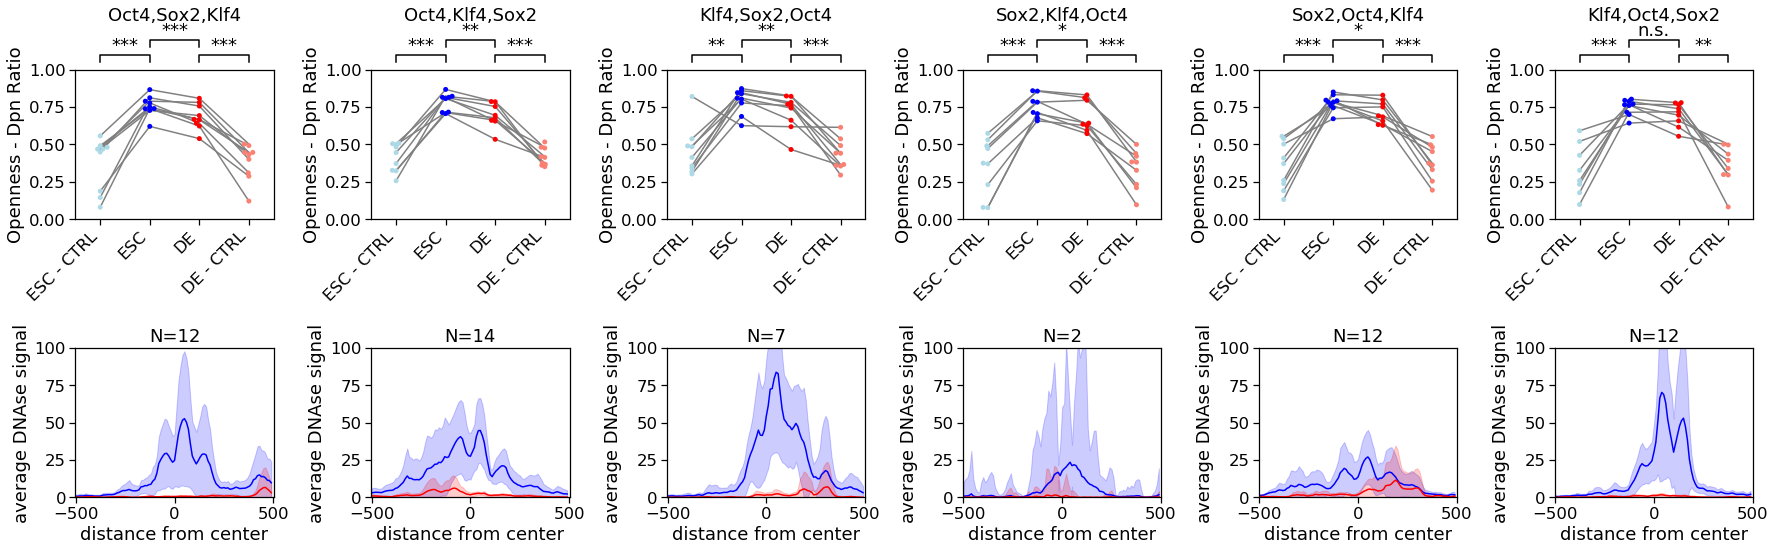

In [94]:
import sys, importlib
importlib.reload(sys.modules['analysis_utils'])
from analysis_utils import *
dnase_OSK = average_ac('data/ES_OSKFGS_locations.txt',['Oct4','Sox2','Klf4'])

plt.figure(figsize=(25,8))

pltind=1
for order in ['Oct4,Sox2,Klf4','Oct4,Klf4,Sox2','Klf4,Sox2,Oct4','Sox2,Klf4,Oct4','Sox2,Oct4,Klf4','Klf4,Oct4,Sox2']:
    cat=order.lower()
    plt.subplot(2,6,pltind)
    tfkeep = data_dpn[data_dpn['cat']==cat]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','cat','distance','control'],keep_pd,title=order)
    pltind+=1
    
for order in ['Oct4,Sox2,Klf4','Oct4,Klf4,Sox2','Klf4,Sox2,Oct4','Sox2,Klf4,Oct4','Sox2,Oct4,Klf4','Klf4,Oct4,Sox2']:
    plt.subplot(2,6,pltind)
    plot_dnase(dnase_OSK,order)
    pltind += 1
    
plt.savefig('plots/compare_OSK_with_genomic_accessibility.svg')

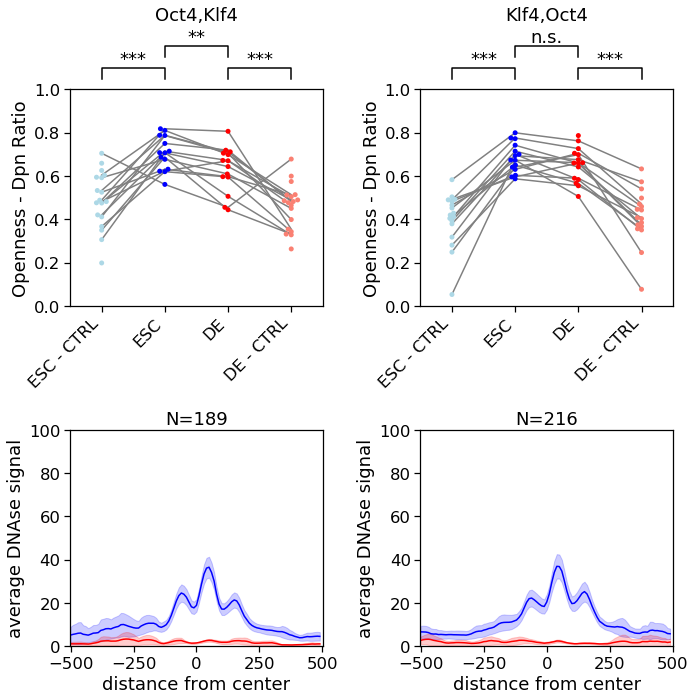

In [95]:
import sys, importlib
importlib.reload(sys.modules['analysis_utils'])
from analysis_utils import *
dnase_OSK = average_ac('data/ES_OSKFGS_locations.txt',['Oct4','Klf4'])

plt.figure(figsize=(10,10))
pltind=1
for order in ['Oct4,Klf4','Klf4,Oct4']:
    cat=order.lower()
    plt.subplot(2,2,pltind)
    tfkeep = data_dpn[data_dpn['cat']==cat]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','cat','distance','control'],keep_pd,title=order)
    pltind+=1
    
for order in ['Oct4,Klf4','Klf4,Oct4']:
    plt.subplot(2,2,pltind)
    plot_dnase(dnase_OSK,order)
    pltind += 1
    
plt.savefig('plots/compare_OK_with_genomic_accessibility.svg')

# genomic importance of Gata4, FoxA2 ordering

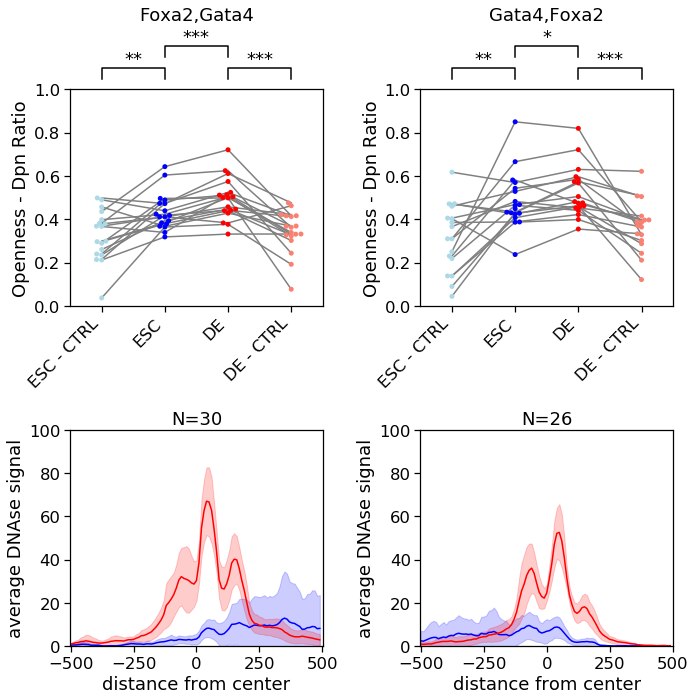

In [96]:
dnase_FG = average_ac('data/ED_OSKFGS_top_locations.txt',['Foxa2','Gata4'])
plt.figure(figsize=(10,10))
pltind=1
for order in ['Foxa2,Gata4','Gata4,Foxa2']:
    cat=order.lower()
    plt.subplot(2,2,pltind)
    tfkeep = data_dpn[data_dpn['cat']==cat]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','cat','distance','control'],keep_pd,title=order)
    pltind+=1
    
for order in ['Foxa2,Gata4','Gata4,Foxa2']:
    plt.subplot(2,2,pltind)
    plot_dnase(dnase_FG,order)
    pltind+=1
    
plt.savefig('plots/compare_FG_with_genomic_accessibility.svg')

# genomic importance of Gata4,Sox17 ordering

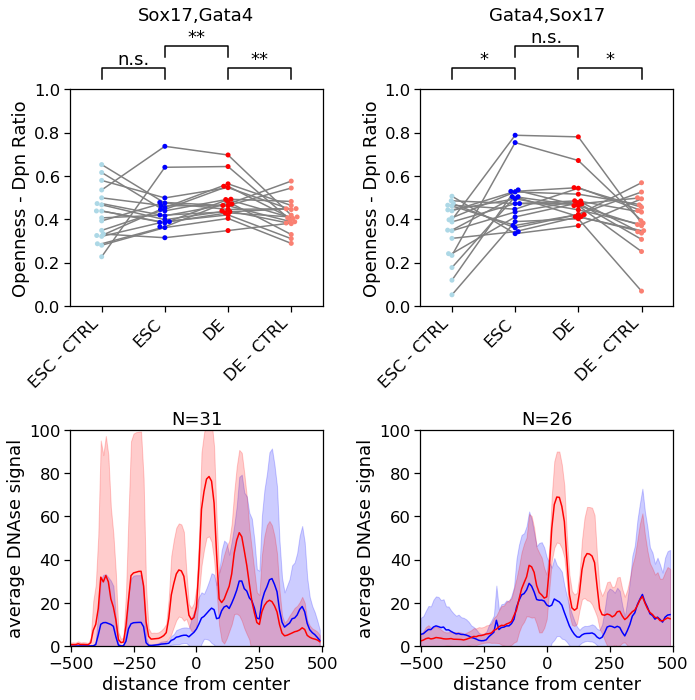

In [97]:
dnase_GS = average_ac('data/ED_OSKFGS_top_locations.txt',['Sox17','Gata4'])
plt.figure(figsize=(10,10))
pltind=1
for order in ['Sox17,Gata4','Gata4,Sox17']:
    cat=order.lower()
    plt.subplot(2,2,pltind)
    tfkeep = data_dpn[data_dpn['cat']==cat]
    keep_pd = tfkeep.pivot_table(index=['background','distance'],
                                   columns=['control'],values=['ES Dpn ratio','ED Dpn ratio']).dropna()
    plot_dotplot(tfkeep,['seq','background','cat','distance','control'],keep_pd,title=order)
    pltind+=1
    
for order in ['Sox17,Gata4','Gata4,Sox17']:
    plt.subplot(2,2,pltind)
    plot_dnase(dnase_GS,order)
    pltind+=1
    
plt.savefig('plots/compare_SG_with_genomic_accessibility.svg')

# just count ordering in top peaks (doesn't work)

In [ ]:
def count_tfs_order(file,tf_names):
    posid_tfs = {}
    header=True
    tf_order_counts = {}
    for i,line in enumerate(open(file)):
        if header:
            header=False
            continue
        data = line.strip().split()
        for tf_name in tf_names:
            if tf_name in data[3]:
                try:
                    curr = posid_tfs[data[0]]
                except KeyError:
                    posid_tfs[data[0]] = []
                posid_tfs[data[0]].append((data[3],data[1]))
    tfs_ordered=[]
    for vlist in [posid_tfs[k] for k in posid_tfs.keys() if len(posid_tfs[k]) == len(tf_names)]:
        tfs = [vp[0] for vp in vlist]
        contains_tf = [False for _ in range(len(tf_names))]
        for tf in tfs:
            for i,tf_name in enumerate(tf_names):
                if tf_name in tf:
                    contains_tf[i] = True
        if np.all(np.array(contains_tf)):
            tfs_order = [t[0].split('(')[0] for t in sorted(vlist,key=lambda x:int(x[1]))]
            tfs_ordered.append(tuple(tfs_order))
    for tf_order in set(tfs_ordered):
        tf_order_counts[','.join(list(tf_order))] = tfs_ordered.count(tf_order)
    return tf_order_counts

In [ ]:
ES_OSK = count_tfs_order('data/ES_OSKFGS_locations.txt',['Oct4','Sox2','Klf4'])
ED_OSK = count_tfs_order('data/ED_OSKFGS_locations.txt',['Oct4','Sox2','Klf4'])
rand_OSK = count_tfs_order('data/random_OSKFGS_locations.txt',['Oct4','Sox2','Klf4'])

In [ ]:
ES_OSK

In [ ]:
sns.barplot(x=list(ES_OSK.keys()),y=list(ES_OSK.values()),
            color='navy',
           order=['Oct4,Sox2,Klf4','Oct4,Klf4,Sox2','Sox2,Klf4,Oct4',
                  'Klf4,Sox2,Oct4','Sox2,Oct4,Klf4','Klf4,Oct4,Sox2'])
plt.xticks(rotation='45',ha='right')
plt.title('occurrence ES specific accessible regions')
plt.show()

In [ ]:
sns.barplot(x=list(ED_OSK.keys()),y=list(ED_OSK.values()),
            color='red',
           order=['Oct4,Sox2,Klf4','Oct4,Klf4,Sox2','Sox2,Klf4,Oct4',
                  'Klf4,Sox2,Oct4','Sox2,Oct4,Klf4','Klf4,Oct4,Sox2'])
plt.xticks(rotation='45',ha='right')
plt.title('occurrence ED specific accessible regions')
plt.show()

In [ ]:
with open('data/ES_only_top.HOMER.bed','w') as f:
    for line in open('data/ES_only_top.bed'):
        data = line.strip().split()
        f.write('\t'.join([data[0],data[1],data[2],data[0]+':'+data[1]+'-'+data[2],'.','+'])+'\n')   
with open('data/ED_only_top.HOMER.bed','w') as f:
    for line in open('data/ED_only_top.bed'):
        data = line.strip().split()
        f.write('\t'.join([data[0],data[1],data[2],data[0]+':'+data[1]+'-'+data[2],'.','+'])+'\n')
subprocess.call(['bedtools random -l 100 -n 100000 -seed 2019 -g /cluster/jhammelm/genomes/atac_mm10/mm10/mm10.chrom.sizes | bedtools intersect -v -a - -b data/ED_only.bed | bedtools intersect -v -a - -b data/ES_only.bed > data/random_seqs.bed'],shell=True)
with open('data/random_seqs.HOMER.bed','w') as f:
    for line in open('data/random_seqs.bed'):
        data = line.strip().split()
        f.write('\t'.join([data[0],data[1],data[2],data[0]+':'+data[1]+'-'+data[2],'.','+']))
        
subprocess.call(['/data/cgs/jhammelm/software/HOMER/bin/findMotifsGenome.pl data/ES_only_top.HOMER.bed mm10 ES_OSKFGS/ -find data/OSKFGS.motif > data/ES_OSKFGS_top_locations.txt'],shell=True)
subprocess.call(['/data/cgs/jhammelm/software/HOMER/bin/findMotifsGenome.pl data/ED_only_top.HOMER.bed mm10 ED_OSKFGS/ -find data/OSKFGS.motif > data/ED_OSKFGS_top_locations.txt'],shell=True)

In [ ]:
ED_GF = count_tfs_order('data/ED_OSKFGS_top_locations.txt',['Foxa2','Gata4'])
ES_GF = count_tfs_order('data/ES_OSKFGS_top_locations.txt',['Foxa2','Gata4'])

In [ ]:
print(ED_GF)
print(ES_GF)

In [ ]:
ED_GS = count_tfs_order('data/ED_OSKFGS_top_locations.txt',['Gata4','Sox17'])
ES_GS = count_tfs_order('data/ES_OSKFGS_top_locations.txt',['Gata4','Sox17'])
print(ED_GS)
print(ES_GS)

# Homotypic vs heterotypic

In [ ]:
keep = data_dpn[data_dpn['cat'].isin([c for c in set(data_dpn['cat']) 
                                      if (('oct4' in c) or ('sox2' in c) or ('klf4' in c))])]
keep['nmotifs'] = [len(c.split(',')) for c in keep['cat']]
keep['nunique'] = [len(set(c.split(','))) for c in keep['cat']]
keep['nunique'] = keep['nunique'].astype('category')
keep['nmotifs'] = keep['nmotifs'].astype('category')
keep['log10 ES/ED'] = np.log10(keep['ES Dpn ratio']) -  np.log10(keep['ED Dpn ratio'])
keep = keep[keep['control']=='motif']
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.violinplot(y='log10 ES/ED',x='nunique',data=keep,color='cornflowerblue')
sns.swarmplot(y='log10 ES/ED',x='nunique',data=keep,color='black')
plt.xlabel('Number of unique motifs')
plt.tight_layout()
plt.subplot(1,2,2)
sns.violinplot(y='log10 ES/ED',x='nmotifs',data=keep,color='cornflowerblue')
sns.swarmplot(y='log10 ES/ED',x='nmotifs',data=keep,color='black')
plt.tight_layout()
plt.xlabel('Number of motifs')
plt.show()

In [ ]:
keep[keep['log10 ES/ED'] < -0.1]

# Stem cell OSK motif analysis

In [ ]:
def ptostar(pval):
    if pval < 0.001:
        return '***'
    elif pval < 0.01:
        return '**'
    elif pval < 0.05:
        return '*'
    else:
        return 'n.s.'

## Number of motifs

In [ ]:
from scipy.stats import ranksums
'''
3) effect of motif order vs "billboard" model
'''
keep = data_dpn[data_dpn['cat'].isin([c for c in set(data_dpn['cat']) if (('oct4' in c) or ('sox2' in c) or ('klf4' in c))])]
keep['nmotifs'] = [len(c.split(',')) for c in keep['cat']]
keep['nunique'] = [len(set(c.split(','))) for c in keep['cat']]
keep['heterotypic'] = keep['nunique'] > 1
keep = keep[keep['control'] == 'motif']

plt.figure(figsize=(5,5))
sns.boxplot('nmotifs','ES Dpn ratio',data=keep,color='cornflowerblue')
sns.swarmplot('nmotifs','ES Dpn ratio',data=keep,color='black')

pval = ptostar(ranksums(keep[keep['nmotifs']==2]['ES Dpn ratio'],
         keep[keep['nmotifs']==1]['ES Dpn ratio'])[1])
x1, x2 = 0, 0.95  
y, h, col = keep[keep['nmotifs']==2]['ES Dpn ratio'].max() + 0.2, 0.2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, pval, ha='center', va='bottom', color=col)

pval = ptostar(ranksums(keep[keep['nmotifs']==3]['ES Dpn ratio'],
         keep[keep['nmotifs']==2]['ES Dpn ratio'])[1])
x1, x2 = 1.05, 2  
y, h, col = keep[keep['nmotifs']==3]['ES Dpn ratio'].max() + 0.2, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, pval, ha='center', va='bottom', color=col)
plt.axis([-0.5,2.5,0,1.6])
plt.xlabel('Number Motifs')
plt.ylabel('Stem Cell Openness - Dpn Ratio')
plt.savefig('plots/stem_cell_accessibility_as_function_number_of_motifs.svg')

## Number unique motifs

In [ ]:
keep = data_dpn[data_dpn['cat'].isin([c for c in set(data_dpn['cat']) if (('oct4' in c) or ('sox2' in c) or ('klf4' in c))])]
keep['nmotifs'] = [len(c.split(',')) for c in keep['cat']]
keep = keep[keep['nmotifs'] > 2]
keep['nunique'] = [len(set(c.split(','))) for c in keep['cat']]
keep['heterotypic'] = keep['nunique'] > 1
keep = keep[keep['control'] == 'motif']

plt.figure(figsize=(5,5))
sns.boxplot('nunique','ES Dpn ratio',data=keep,color='cornflowerblue')
sns.swarmplot('nunique','ES Dpn ratio',data=keep,color='black')

pval = ptostar(ranksums(keep[keep['nunique']==3]['ES Dpn ratio'],
         keep[keep['nunique']==1]['ES Dpn ratio'])[1])
x1, x2 = 0, 0.95  
y, h, col = keep[keep['nunique']==3]['ES Dpn ratio'].max() + 0.2, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, pval, ha='center', va='bottom', color=col)

#pval = ptostar(ranksums(keep[keep['nunique']==3]['ES Dpn ratio'],
#         keep[keep['nunique']==2]['ES Dpn ratio'])[1])
#x1, x2 = 1.05, 2  
#y, h, col = keep[keep['nunique']==3]['ES Dpn ratio'].max() + 0.2, 0.1, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, pval, ha='center', va='bottom', color=col)
#plt.axis([-0.5,2.5,0,1.6])
plt.xlabel('Number Unique Motifs')
plt.ylabel('Stem Cell Openness - Dpn Ratio')
#plt.savefig('plots/stem_cell_accessibility_as_function_number_of_unique.svg')
plt.show()

## Motif order

In [ ]:
keep = data_dpn[data_dpn['cat'].isin([c for c in set(data_dpn['cat']) if (('oct4' in c) or ('sox2' in c) or ('klf4' in c))])]
keep['nmotifs'] = [len(c.split(',')) for c in keep['cat']]
keep['nunique'] = [len(set(c.split(','))) for c in keep['cat']]
keep['heterotypic'] = keep['nunique'] > 1
keep = keep[keep['control'] == 'motif']
print(set(keep['cat']))
keep = keep[keep['nmotifs']==2]
plt.figure(figsize=(5,5))
sns.boxplot(x='cat',y='ES Dpn ratio',data=keep,color='cornflowerblue')
sns.swarmplot(x='cat',y='ES Dpn ratio',data=keep,color='black')

keep_paired = keep.pivot_table(index=['background'],columns=['cat'],values=['ES Dpn ratio']).dropna()
print(keep_paired.head())
pval = ptostar(wilcoxon(keep_paired['ES Dpn ratio']['sox2,oct4'],
         keep_paired['ES Dpn ratio']['oct4,sox2'])[1])
x1, x2 = 0,1  
y, h, col = keep[keep['cat']=='oct4,sox2']['ES Dpn ratio'].max() + 0.2, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, pval, ha='center', va='bottom', color=col)

pval = ptostar(wilcoxon(keep_paired['ES Dpn ratio']['klf4,oct4'],
         keep_paired['ES Dpn ratio']['oct4,klf4'])[1])
x1, x2 = 2,3  
y, h, col = keep[keep['cat']=='oct4,klf4']['ES Dpn ratio'].max() + 0.2, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, pval, ha='center', va='bottom', color=col)

pval = ptostar(wilcoxon(keep_paired['ES Dpn ratio']['klf4,sox2'],
         keep_paired['ES Dpn ratio']['sox2,klf4'])[1])
x1, x2 = 4,5  
y, h, col = keep[keep['cat']=='sox2,klf4']['ES Dpn ratio'].max() + 0.2, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, pval, ha='center', va='bottom', color=col)

plt.axis([-0.5,8.5,0,1.6])

plt.xlabel('')
plt.ylabel('Stem Cell Openness - Dpn Ratio')
plt.xticks(rotation=45, ha='right')
#plt.savefig('plots/stem_cell_accessibility_sox2_oct4.svg')
plt.show()

# FGS analysis

In [ ]:
from scipy.stats import ranksums
'''
3) effect of motif order vs "billboard" model
'''
keep = data_dpn[data_dpn['cat'].isin([c for c in set(data_dpn['cat']) if (('foxa2' in c) or ('gata4' in c) or ('sox17' in c))])]
keep['nmotifs'] = [len(c.split(',')) for c in keep['cat']]
keep['nunique'] = [len(set(c.split(','))) for c in keep['cat']]
keep['heterotypic'] = keep['nunique'] > 1
keep = keep[keep['control'] == 'motif']

plt.figure(figsize=(5,5))
sns.boxplot('nmotifs','ED Dpn ratio',data=keep,color='red')
sns.swarmplot('nmotifs','ED Dpn ratio',data=keep,color='black')

pval = ptostar(ranksums(keep[keep['nmotifs']==2]['ED Dpn ratio'],
         keep[keep['nmotifs']==1]['ED Dpn ratio'])[1])
x1, x2 = 0, 0.95  
y, h, col = keep[keep['nmotifs']==2]['ED Dpn ratio'].max() + 0.2, 0.2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, pval, ha='center', va='bottom', color=col)

pval = ptostar(ranksums(keep[keep['nmotifs']==3]['ED Dpn ratio'],
         keep[keep['nmotifs']==2]['ED Dpn ratio'])[1])
x1, x2 = 1.05, 2  
y, h, col = keep[keep['nmotifs']==3]['ED Dpn ratio'].max() + 0.2, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, pval, ha='center', va='bottom', color=col)
plt.axis([-0.5,2.5,0,1.6])
plt.xlabel('Number Motifs')
plt.ylabel('DE Openness - Dpn Ratio')
plt.savefig('plots/de_cell_accessibility_as_function_number_of_motifs.svg')

In [ ]:
keep = data_dpn[data_dpn['cat'].isin([c for c in set(data_dpn['cat']) if (('foxa2' in c) or ('gata4' in c) or ('sox17' in c))])]
keep['nmotifs'] = [len(c.split(',')) for c in keep['cat']]
keep = keep[keep['nmotifs'] > 2]
keep['nunique'] = [len(set(c.split(','))) for c in keep['cat']]
keep['heterotypic'] = keep['nunique'] > 1
keep = keep[keep['control'] == 'motif']

plt.figure(figsize=(5,5))
sns.boxplot('nunique','ED Dpn ratio',data=keep,color='red')
sns.swarmplot('nunique','ED Dpn ratio',data=keep,color='black')

pval = ptostar(ranksums(keep[keep['nunique']==3]['ED Dpn ratio'],
         keep[keep['nunique']==1]['ED Dpn ratio'])[1])
x1, x2 = 0, 0.95  
y, h, col = keep[keep['nunique']==3]['ED Dpn ratio'].max() + 0.2, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, pval, ha='center', va='bottom', color=col)

#pval = ptostar(ranksums(keep[keep['nunique']==3]['ES Dpn ratio'],
#         keep[keep['nunique']==2]['ES Dpn ratio'])[1])
#x1, x2 = 1.05, 2  
#y, h, col = keep[keep['nunique']==3]['ES Dpn ratio'].max() + 0.2, 0.1, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, pval, ha='center', va='bottom', color=col)
#plt.axis([-0.5,2.5,0,1.6])
plt.xlabel('Number Unique Motifs')
plt.ylabel('DE Openness - Dpn Ratio')
#plt.savefig('plots/stem_cell_accessibility_as_function_number_of_unique.svg')
plt.show()

In [ ]:
keep = data_dpn[data_dpn['cat'].isin([c for c in set(data_dpn['cat']) if (('foxa2' in c) or ('gata4' in c) or ('sox17' in c))])]
keep['nmotifs'] = [len(c.split(',')) for c in keep['cat']]
keep['nunique'] = [len(set(c.split(','))) for c in keep['cat']]
keep['heterotypic'] = keep['nunique'] > 1
keep = keep[keep['control'] == 'motif']
print(set(keep['cat']))
keep = keep[keep['nmotifs']==2]
plt.figure(figsize=(5,5))
sns.boxplot(x='cat',y='ED Dpn ratio',data=keep,color='red')
sns.swarmplot(x='cat',y='ED Dpn ratio',data=keep,color='black')
'''
keep_paired = keep.pivot_table(index=['background'],columns=['cat'],values=['ES Dpn ratio']).dropna()
print(keep_paired.head())
pval = ptostar(wilcoxon(keep_paired['ES Dpn ratio']['sox2,oct4'],
         keep_paired['ES Dpn ratio']['oct4,sox2'])[1])
x1, x2 = 0,1  
y, h, col = keep[keep['cat']=='oct4,sox2']['ES Dpn ratio'].max() + 0.2, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, pval, ha='center', va='bottom', color=col)

pval = ptostar(wilcoxon(keep_paired['ES Dpn ratio']['klf4,oct4'],
         keep_paired['ES Dpn ratio']['oct4,klf4'])[1])
x1, x2 = 2,3  
y, h, col = keep[keep['cat']=='oct4,klf4']['ES Dpn ratio'].max() + 0.2, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, pval, ha='center', va='bottom', color=col)

pval = ptostar(wilcoxon(keep_paired['ES Dpn ratio']['klf4,sox2'],
         keep_paired['ES Dpn ratio']['sox2,klf4'])[1])
x1, x2 = 4,5  
y, h, col = keep[keep['cat']=='sox2,klf4']['ES Dpn ratio'].max() + 0.2, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, pval, ha='center', va='bottom', color=col)

plt.axis([-0.5,8.5,0,1.6])
'''

plt.xlabel('')
plt.ylabel('DE Openness - Dpn Ratio')
plt.xticks(rotation=45, ha='right')
#plt.savefig('plots/stem_cell_accessibility_sox2_oct4.svg')
plt.show()
